In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math as math
import numpy as np
import copy as copy
from IPython import display
import gc
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 38

In [2]:
from matplotlib.ticker import FuncFormatter
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def formatter(x,pos):
    return format(np.log10(x), '.0f')

In [3]:
# ##########################################################
# Generate colors for histogram bars based on a normalized
# height. Normalize by bin width and comoving vol
# Method:
#  Take log of the histogram values (weighted counts)..
#  Create a LogNorm mapping between 1->max
#  Use the norm to map scalar values between 1 & max to rgb
# ##########################################################
def colorHistOnHeight(N, bins, patches, cmvol, minc, maxc):
    cleanN = np.ma.masked_where(N == 0.0, N)
    widths = np.diff(np.log10(bins))
    fracs  = np.log10(cleanN/widths/cmvol)

    # normalize colors to the top of our scale
    norm   = mpl.colors.LogNorm(vmin=minc, vmax=maxc) 
    sm     = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    sm.set_clim([minc, maxc]) # Force to use the whole range
    for thisfrac, thispatch in zip(fracs, patches):
        color = sm.to_rgba(thisfrac)
        thispatch.set_facecolor(color)
    return 
# ##########################################################
# Normalizes the histogram's bar height by the bin width
# and comoving volume of the simulation
# ##########################################################
def normBarHeight(bins, patches, cmvol, rotated=False):
    widths = np.diff(np.log10(bins))
    #print ("patches %i, bins %i"%(len(patches),len(widths)))
    for item,dbx in zip(patches,widths):
        #print ("Starting height: %.2f bin width: %.2e"%(item.get_height(),dbx))
        if not rotated:
            item.set_height(item.get_height()/dbx/cmvol)
        else:
            item.set_width(item.get_width()/dbx/cmvol)
        #print ("Ending width: %.2f"%item.get_width())
    return

In [4]:
custom_formatter = FuncFormatter(formatter)

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_2dhist = [left, bottom, width, height]
rect_histx = [left, bottom_h, width - 0.13, 0.15]
rect_histy = [left_h, bottom, 0.15, height]
labelsize = 34

In [5]:
prefix = "./"
z = "05.00"
locs   = np.loadtxt(prefix + "spLoc_" + z + ".txt", skiprows=1)
masses = np.loadtxt(prefix + "spMass_" + z + ".txt", skiprows=1)
spZ  = np.loadtxt(prefix + "spZ_" + z + ".txt", skiprows=1)
spPZ = np.loadtxt(prefix + "spPZ_" + z + ".txt", skiprows=1)
spPF = np.loadtxt(prefix + "spPPF_" + z + ".txt", skiprows=1)

In [6]:
Zcrit = 1e-5 # solar

fpol = (1-spPF)
fpol[fpol<1e-5] = 0 # ## MODIFIED from 1e-6 to 1e-5 July 2016
# Don't let tiny numbers magnify Z !! Just use Z = 0 for these guys
### Does it make sense to have fpol < 10^-4 or so since our average star particle is 750 M_sun?? Once you are below
### .1 solar mass this doesn't represent an enhanced pollution of a single star, but enhanced pollution of a 
### single star 
# Do the correcting before fixing Z for subcritical values... otherwise, we bias Z/f_pol
Zf= (spZ - spPF * Zcrit)/fpol # This is our Z corrected for f_pol
Zf[np.isinf(Zf)] = 10**-8.5 # Fix Zf for sp's with very very low polluted fractions. They are essentially pristine
Zf[np.isnan(Zf)] = 10**-8.5
#Zf[Zf<1e-5] = 10**-7.5

PZf=spPZ/fpol
PZf[np.isinf(PZf)] = 10**-8.5
PZf[np.isnan(PZf)] = 10**-8.5

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in divide
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


In [7]:
# Determine which stars are completely primordial (PM) at this redshift.
spZmPZCond = (Zf - PZf)
priStars = (spZmPZCond == 0.0) # This is a conditional check. Selects star particles with only PM
mixedStar = (spZmPZCond > 0.0) # Select stars with both primordial and regular metals

## 25 M_sun Pop III SN mass fractions, Nomoto
<|H -> 67.2466, He -> 36.2852, 
 C -> 0.864672, N -> 0.00100878, O -> 0.13237, 
 F -> 7.35231*10^-10, Ne -> 0.00181426, Na -> 1.07003*10^-7, 
 Mg -> 0.0000405398, Al -> 1.28539*10^-7, Si -> 0.0000242565, 
 P -> 6.74577*10^-9, S -> 0.0000142174, Cl -> 9.36997*10^-9, 
 Ar -> 2.68986*10^-6, K -> 2.81018*10^-9, Ca -> 3.71304*10^-6, 
 Sc -> 2.69701*10^-11, Ti -> 5.73999*10^-8, V -> 2.31868*10^-9, 
 Cr -> 9.63105*10^-7, Mn -> 1.57773*10^-7, Fe -> 0.0000474087, 
 Co -> 3.87723*10^-8, Ni -> 6.47289*10^-7|>
 ## 60 M_sun Pop III SN mass fractions, Heger
 <|H -> 787.904, He -> 636.082, 
 C -> 0.711729, N -> 0.000949252, O -> 0.273221, 
 F -> 1.7175*10^-6, Ne -> 0.0131384, Na -> 1.89183*10^-6, 
 Mg -> 0.000956191, Al -> 8.26108*10^-7, Si -> 2.18676*10^-6, 
 P -> 1.62811*10^-8, S -> 3.13468*10^-8, Cl -> 3.07894*10^-10, 
 Ar -> 1.00391*10^-9, K -> 3.7441*10^-10, Ca -> 1.43246*10^-7, 
 Sc -> 5.0064*10^-12, Ti -> 2.45711*10^-11, V -> 1.49119*10^-12, 
 Cr -> 5.15296*10^-12, Mn -> 2.86712*10^-13, Fe -> 2.63816*10^-12, 
 Co -> 3.32158*10^-13, Ni -> 1.77383*10^-12|>
 
## Sun's mass fractions, X_{i,sun}
 Use these values when modeling solar metal fractions
 Solar values based on Asplund
<|H -> 0.735999, He -> 0.250575, 
 C -> 0.00237716, N -> 0.000696635, O -> 0.00576763, 
 F -> 5.07728*10^-7, Ne -> 0.00125287, Na -> 0.0000294175, 
 Mg -> 0.000703216, Al -> 0.0000560069, Si -> 0.000666861, 
 P -> 5.86461*10^-6, S -> 0.000310476, Cl -> 8.14602*10^-6, 
 Ar -> 0.0000739499, K -> 3.07569*10^-6, Ca -> 0.0000644076, 
 Sc -> 4.67832*10^-8, Ti -> 3.14861*10^-6, V -> 3.19483*10^-7, 
 Cr -> 0.0000167063, Mn -> 0.0000108953, Fe -> 0.00130336, 
 Co -> 4.24355*10^-6, Ni -> 0.0000708444|>
 ## Asplunds's solar metal mass fractions -- based on solar metals only
  Only use elements C, N, O, ... These are metal fractions: i.e. - X/Sum(X_i,{X_c,X_ni})
  Only need to use these if I want to scale my Z's to the sun's fractions
<|H -> 54.8198, He -> 18.6637, 
 C -> 0.177059, N -> 0.0518878, O -> 0.273221, 
 F -> 0.0000378173, Ne -> 0.0933184, Na -> 0.00219112, Mg -> 0.052378,
  Al -> 0.00417159, Si -> 0.0496701, P -> 0.000436817, S -> 0.0231253,
  Cl -> 0.000606744, Ar -> 0.00550804, K -> 0.000229088, 
 Ca -> 0.00479731, Sc -> 3.48458*10^-6, Ti -> 0.000234519, 
 V -> 0.0000237962, Cr -> 0.00124434, Mn -> 0.000811522, 
 Fe -> 0.097079, Co -> 0.000316074, Ni -> 0.00527674|>

In [8]:
# Metal Mass-fractions for 25 M_sun Pop III SN
C25sn = 0.864672; N25sn =0.00100878; O25sn = 0.13237; Mg25sn = 0.0000405398; Ca25sn = 3.71304e-6;Fe25sn = 0.0000474087;
# Metal Mass-fractions for 60 M_sun Pop III SN - Heger, StarFit.org and Keller SMSS J031300.362670839.3 obs data
C60sn = 0.711729; N60sn =0.000949252; O60sn = 0.273221; Mg60sn = 0.000956191; Ca60sn = 1.43246e-7;Fe60sn = 2.63816e-12;
# Metal Mass-fractions for 1 Gyr ave ejecta - Franks model
Cf = 0.168153 ; Nf =0.0792975; Of = 0.528584 ; Mgf=0.0249245; Caf=0.00300647 ;Fef = 0.0539277;

# Solar metal mass fractions based on Asplund's solar abundances - use to scale my Z's to solar fraction
# if I want a component of the star to map to solar metallicity (by Asplund)
Csunmetal = 0.177059; Nsunmetal =0.0518878; Osunmetal = 0.429593; Mgsunmetal= 0.052378; Casunmetal=0.00479731;Fesunmetal = 0.097079; 
# Used to normalize the mass fractions and convert to number densities.
Csun = 0.00237716; Nsun =0.000696635; Osun = 0.00576763; Mgsun=0.000703216; Casun=0.0000644076; Fesun = 0.00130336; 

In [9]:
# Compute fractions of PM based on 25 M_sun Pop III SN abundances 
# spPZ is already in solar units (i.e. if spPZ = 1.0 we have solar metallicity for that star particle),
# so convert spPZ back to mass fraction first. 
# What we're doing: (Z_P * 0.02) * X_sn results in the mass fraction of that element as if it came from that SN
CH = PZf[priStars] * 0.02 * C25sn
NH = PZf[priStars] * 0.02 * N25sn
OH = PZf[priStars] * 0.02 * O25sn
MgH = PZf[priStars] * 0.02 * Mg25sn
CaH = PZf[priStars] * 0.02 * Ca25sn
FeH = PZf[priStars] * 0.02 * Fe25sn

# Mass fractions of the elements in our primordial metals ... mass-fraction of metals units
C60 = PZf[priStars] * 0.02 * C60sn
N60 = PZf[priStars] * 0.02 * N60sn
O60 = PZf[priStars] * 0.02 * O60sn
Mg60 = PZf[priStars] * 0.02 * Mg60sn
Ca60 = PZf[priStars] * 0.02 * Ca60sn
Fe60 = PZf[priStars] * 0.02 * Fe60sn

In [10]:
# For stars with regular Z and PZ, assume solar composition for regular Z, and the yields from a 25 M Pop III SN
# for the PM part. 
CH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Csunmetal + PZf[mixedStar] * 0.02 * C25sn
NH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Nsunmetal + PZf[mixedStar] * 0.02 * N25sn
OH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Osunmetal + PZf[mixedStar] * 0.02 * O25sn
FeH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Fesunmetal + PZf[mixedStar] * 0.02 * Fe25sn
MgH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Mgsunmetal + PZf[mixedStar] * 0.02 * Mg25sn
CaH_mixedS25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Casunmetal + PZf[mixedStar] * 0.02 * Ca25sn
# Note that we if Osun and Csun, etc. were standard solar metal mass fractions I could just multiply Z by Csun,etc.
# However, since the Asplund data doesn't result in a 0.02 solar metal fraction, we need to normalize Z by 0.02 
# and then multiply by the Asplund metal fractions...
# 
# Next we should use Frank's results to scale the "regular Z" since it really isn't "regular", but Fe depleted.
#
CH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Cf + PZf[mixedStar] * 0.02 * C25sn
NH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Nf + PZf[mixedStar] * 0.02 * N25sn
OH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Of + PZf[mixedStar] * 0.02 * O25sn
MgH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Mgf + PZf[mixedStar] * 0.02 * Mg25sn
CaH_mixedF25  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Caf + PZf[mixedStar] * 0.02 * Ca25sn
FeH_mixedF25 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Fef + PZf[mixedStar] * 0.02 * Fe25sn

# Use Franks for normal and Heger 60 M_sun or primordial.
#
C_mixedF60  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Cf + PZf[mixedStar] * 0.02 * C60sn
N_mixedF60  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Nf + PZf[mixedStar] * 0.02 * N60sn
O_mixedF60  = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Of + PZf[mixedStar] * 0.02 * O60sn
Mg_mixedF60 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Mgf + PZf[mixedStar] * 0.02 * Mg60sn
Ca_mixedF60 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Caf + PZf[mixedStar] * 0.02 * Ca60sn
Fe_mixedF60 = (Zf[mixedStar]-PZf[mixedStar]) * 0.02 * Fef + PZf[mixedStar] * 0.02 * Fe60sn


In [11]:
# Keller data
CHFeH = np.loadtxt("/Users/earnric/Google Drive/ASU/Research-PristineGas/Write-up/Keller star data/CH-FeH.txt", skiprows=1);
OHFeH = np.loadtxt("/Users/earnric/Google Drive/ASU/Research-PristineGas/Write-up/Keller star data/OH-FeH Keller.txt", skiprows=1);
MgCaFeH = np.loadtxt("/Users/earnric/Google Drive/ASU/Research-PristineGas/Write-up/Keller star data/MgCa-FeH Keller.txt", skiprows=1);

In [12]:
# The O values are upper bounds. Need error bars for them in plots
Oindices=[[0,1],[2*4,2*4+1],[2*5,2*5+1],[2*8,2*8+1],[2*11,2*11+1],[2*12,2*12+1],[2*15,2*15+1]]

cmvol = 27.0 / (0.71)**3 # We're 'per h' so the volume is bigger than 27 Mpc^3

In [13]:
print("Mass fractions")
print("60M SN Mg=%.2e  Ca=%.2e  Fe=%.2e"%(Mg60sn,Ca60sn,Fe60sn))
print("Sun    Mg=%.2e  Ca=%.2e  Fe=%.2e"%(Mgsun,Casun,Fesun))
print("Frank  Mgf=%.2e Caf=%.2e Fef=%.2e"%(Mgf,Caf,Fef))
print("All SN Mgf=%.2e Caf=%.2e Fef=%.2e"%((Mg60sn)/Mgsun,Ca60sn/Casun,Fe60sn/Fesun))
print('Mixed 10%% Frank and 90%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.1*Mgf+.9*Mg60sn)/Mgsun, (.1*Caf+.9*Ca60sn)/Casun, (.1*Fef+.9*Fe60sn)/Fesun))
print('Mixed 20%% Frank and 80%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.2*Mgf+.8*Mg60sn)/Mgsun, (.2*Caf+.8*Ca60sn)/Casun, (.2*Fef+.8*Fe60sn)/Fesun))
print('Mixed 30%% Frank and 70%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.3*Mgf+.7*Mg60sn)/Mgsun, (.3*Caf+.7*Ca60sn)/Casun, (.3*Fef+.7*Fe60sn)/Fesun))
print('Mixed 40%% Frank and 60%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.4*Mgf+.6*Mg60sn)/Mgsun, (.4*Caf+.6*Ca60sn)/Casun, (.4*Fef+.6*Fe60sn)/Fesun))
print('Mixed 50%% Frank and 50%% 60M SN, solar units: Mg=%.2e Ca=%.2e Fe=%.2e'%
      ((.5*Mgf+.5*Mg60sn)/Mgsun, (.5*Caf+.5*Ca60sn)/Casun, (.5*Fef+.5*Fe60sn)/Fesun))

Mass fractions
60M SN Mg=9.56e-04  Ca=1.43e-07  Fe=2.64e-12
Sun    Mg=7.03e-04  Ca=6.44e-05  Fe=1.30e-03
Frank  Mgf=2.49e-02 Caf=3.01e-03 Fef=5.39e-02
All SN Mgf=1.36e+00 Caf=2.22e-03 Fef=2.02e-09
Mixed 10% Frank and 90% 60M SN, solar units: Mg=4.77e+00 Ca=4.67e+00 Fe=4.14e+00
Mixed 20% Frank and 80% 60M SN, solar units: Mg=8.18e+00 Ca=9.34e+00 Fe=8.28e+00
Mixed 30% Frank and 70% 60M SN, solar units: Mg=1.16e+01 Ca=1.40e+01 Fe=1.24e+01
Mixed 40% Frank and 60% 60M SN, solar units: Mg=1.50e+01 Ca=1.87e+01 Fe=1.66e+01
Mixed 50% Frank and 50% 60M SN, solar units: Mg=1.84e+01 Ca=2.33e+01 Fe=2.07e+01


In [14]:
gc.collect()

24

In [15]:
xrange = np.logspace(-9,0,181)
yrange = np.logspace(-9,0,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]_{60M_{\odot},1Gyr}\,f_{pol}"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 14))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeThree, = ax2dhist.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ax2dhist.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=60.0 ) 

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.75))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[O/H]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', markersize=10,
                  yerr=0.3*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ax2dhist.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', markersize=10,
                  xerr=4e-1*10**OHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=180, c="r" ,marker=(5,1))
gc.collect()
#plt.savefig("OH60F_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


414

/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


436

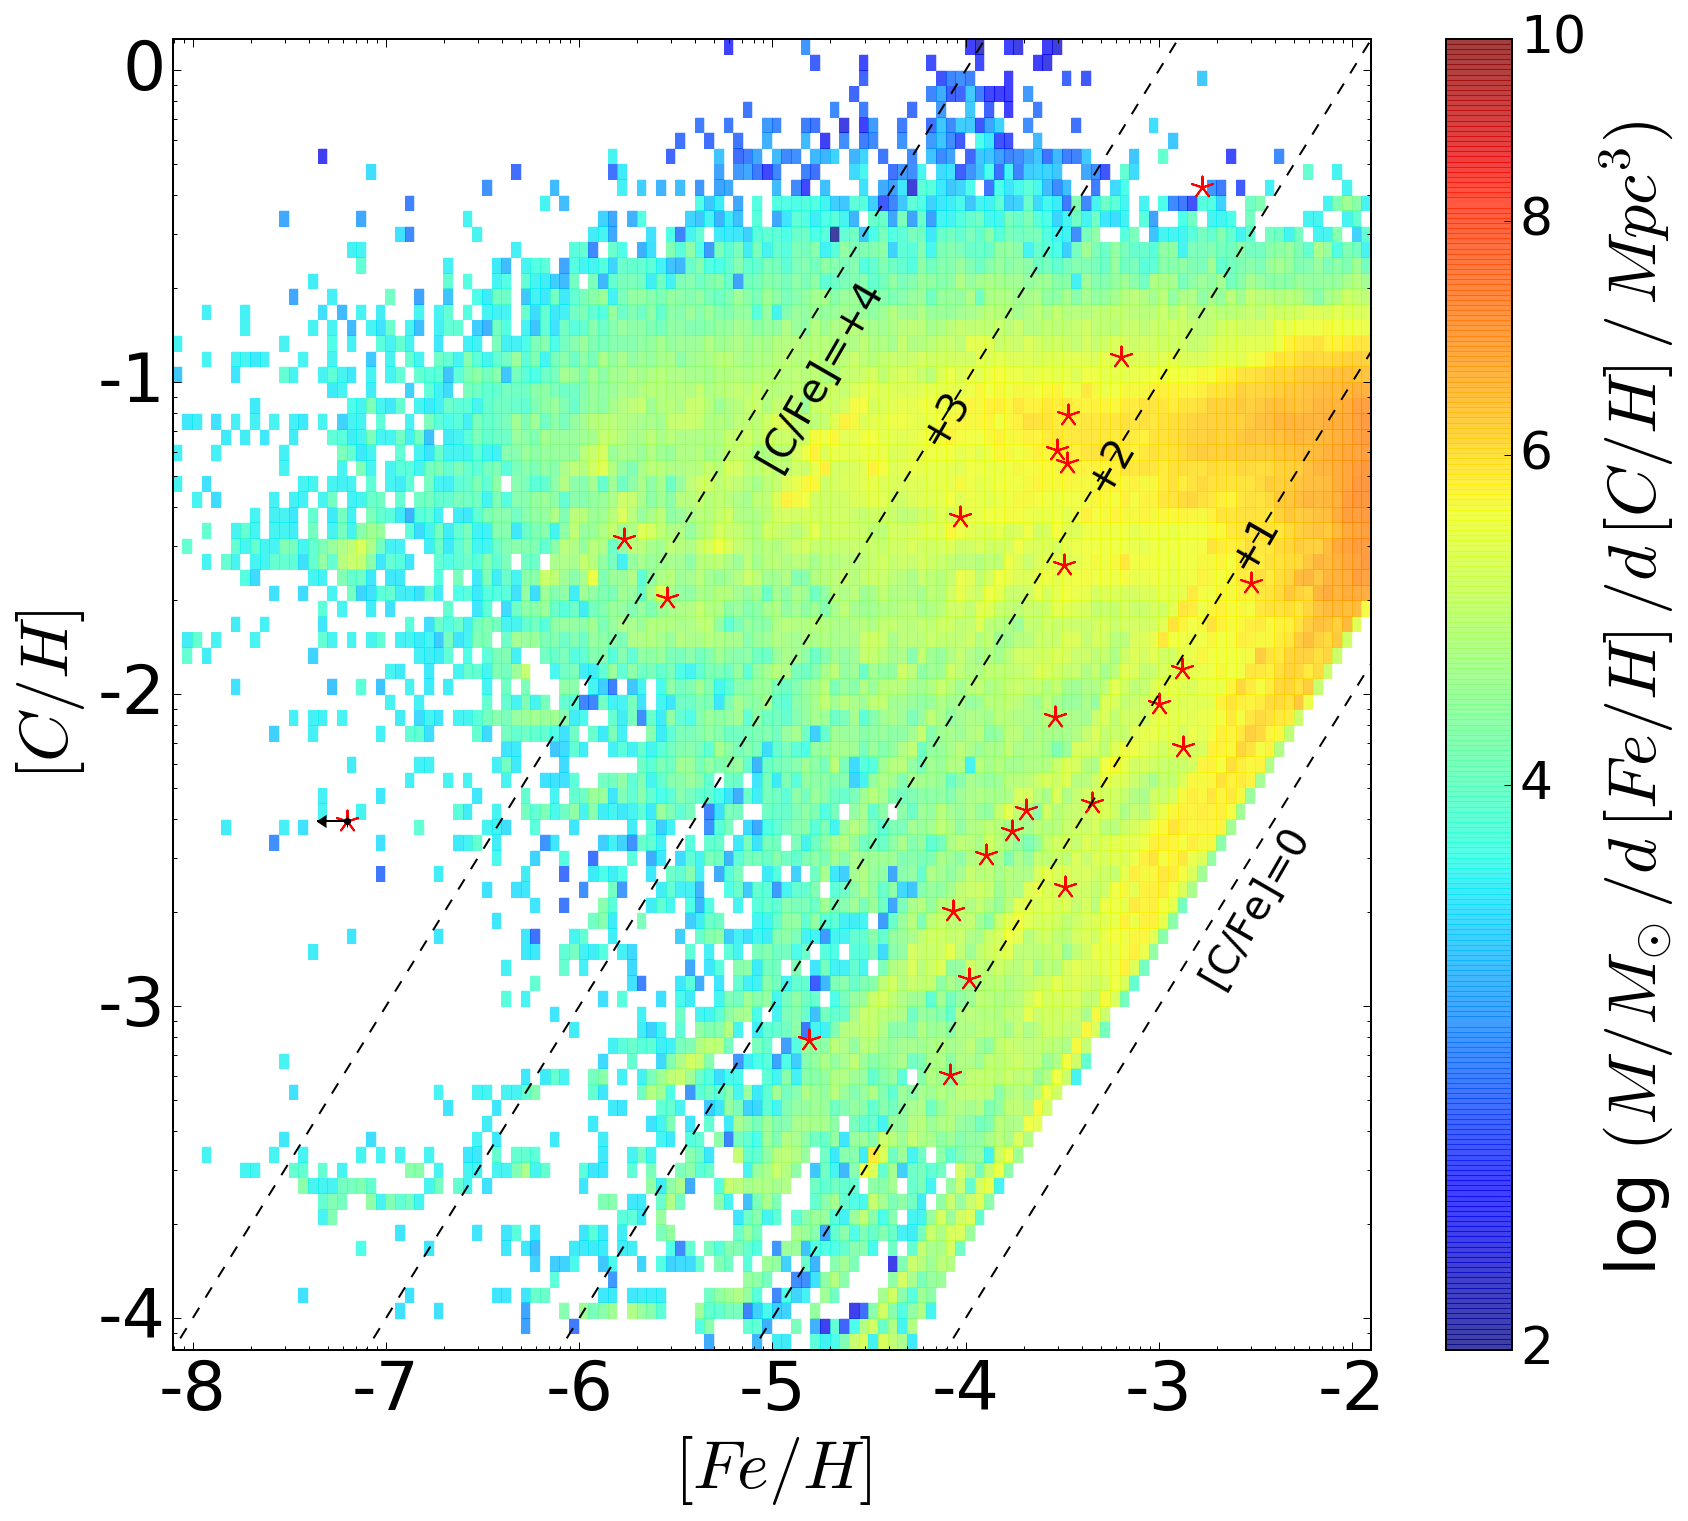

In [16]:
xrange = np.logspace(-9,0,181)
yrange = np.logspace(-8,1,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]_{60M_{\odot},1Gyr}\,f_{pol}"
yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 14))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=60.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax), alpha=0.75))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[C/H]\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi)

# Add Keller CEMP star points
ax2dhist.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ax2dhist.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))

plt.savefig("CH60F_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')
gc.collect()

In [31]:
gc.collect()

29123

In [27]:
xrange = np.logspace(-9,0,181)
yrange = np.logspace(-4,4,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]_{60M_{\odot},1Gyr}"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 14))
axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
boxAspect = (maxY-minY)/(maxX-minX)
cbarMin = 2
cbarMax = 10

histMax = 8
nullfmt = NullFormatter()

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}$", size=34)
ax2dhist.set_xlabel("$[Fe/H]$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.75))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[Mg/Ca]\, /\, Mpc^{3})$ ", size=34)

# Add Keller CEMP star points
ax2dhist.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
ax2dhist.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))


cfeZero,  = ax2dhist.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim(ax2dhist.get_xlim())  # Match the x range on the horiz hist
axHistx.set_ylim([1e2,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e2, 1e4, 1e6,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks

plt.savefig("MgCa60F_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/earnric/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [35]:
xrange = np.logspace(-9,0,181)
yrange = np.logspace(-9,0,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[N/H]_{60M_{\odot},1Gyr}\,f_{pol}"
H, xedges, yedges = np.histogram2d(N_mixedF60/Nsun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

fig = plt.figure(figsize=(16, 15))
#axHistx = plt.axes(rect_histx)
ax2dhist = plt.axes(rect_2dhist)
#axHisty = plt.axes(rect_histy)

histMax = 8
cbarMin = 2
cbarMax = 10

minY = -7.1; maxY = -0.1
minX = -8.1; maxX = -1.9

ax2dhist.tick_params(axis='x', labelsize=labelsize)
ax2dhist.tick_params(axis='y', labelsize=labelsize)
ax2dhist.set_xlabel("$[Fe/H]_{60M_{\odot},1Gyr}\,f_{pol}$", size=34)
ax2dhist.set_ylabel("$"+yLabel+"$", size=34)
    
ax2dhist.set_xlim([10**minX,10**maxX])
ax2dhist.set_ylim([10**minY,10**maxY])
ax2dhist.set_xscale('log')
ax2dhist.set_yscale('log')

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ax2dhist.annotate('[N/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeOne,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ax2dhist.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=60.0 ) 
cfeTwo,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ax2dhist.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeThree,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ax2dhist.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=60.0)
cfeFour,  = ax2dhist.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ax2dhist.annotate('[N/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-5.0, 10**-1.0), 
                  horizontalalignment='center',size=20,rotation=60.0)

ax2dhist.xaxis.set_major_formatter(custom_formatter)
ax2dhist.yaxis.set_major_formatter(custom_formatter)

# Fix colors -- white for values of 1.0. 
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
# Create a plot of the binned data, use a fixed lognormal scale
cax = (ax2dhist.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax), alpha=0.55))
cbarticks = [2,4,6, 8, cbarMax]
cbar = fig.colorbar(cax, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[N/H]\, /\, Mpc^{3})$ ", size=34)
#plt.savefig("carbon_composit.pdf", dpi=fig.dpi,bbox_inches='tight')



/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


# MDF

/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


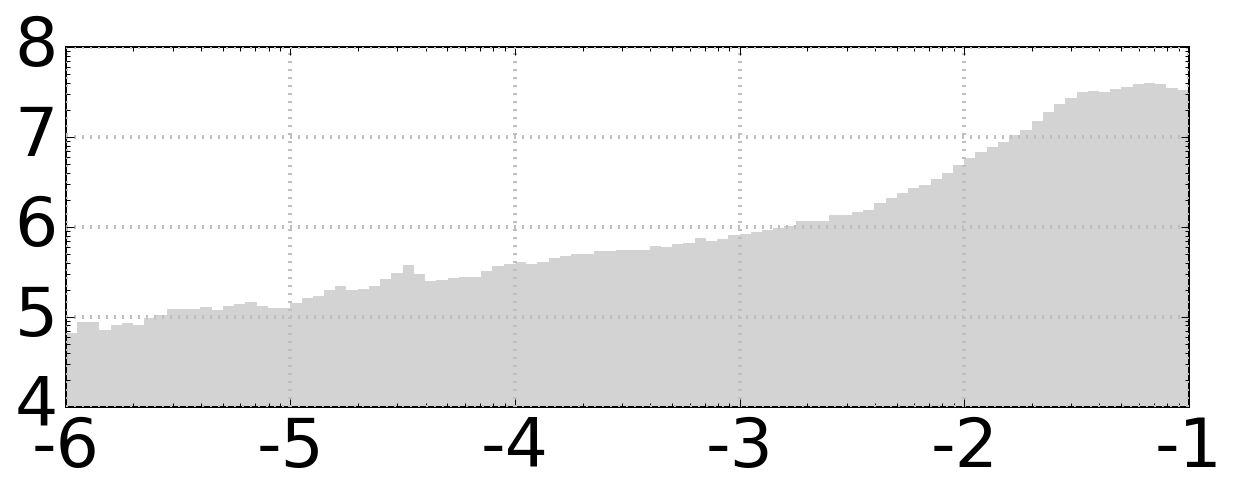

In [15]:
xrange = np.logspace(-9,0,181)
axHistx = plt.axes(rect_2dhist)

cbarMin = 2
cbarMax = 10
histMax = 8
# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none', color='lightgrey',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))

## #####################
# Normalization factor
# Need this since normBarHeight() below divides out bin width and comoving volume
## #####################
Nnormed=np.log10(N/np.diff(np.log10(bins))/cmvol)
## #####################
## #####################

normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([1e-6,1e-1])  # Match the x range on the horiz hist
axHistx.set_ylim([1e4,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e4,1e5,1e6,1e7,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_aspect(0.4)
#axHistx.plot(timsStarsPaperBinned[:,0],timsStarsPaperBinned[:,1]/max(timsStarsPaperBinned[:,1]) * )

## These scale factors depend on the bins being nicely selected: with boundaries on the integer powers of 10

In [16]:
# Scaling by the first data point in the range (highest)
scaleAt2=Nnormed[bins==1e-2]
scaleAt3=Nnormed[bins==10**-2.8]
print(np.log10(scaleAt2),np.log10(scaleAt3))

(array([ 0.83055843]), array([ 0.77847205]))


/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181
  from ipykernel import kernelapp as app
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181
  app.launch_new_instance()


In [17]:
bins[(bins<=1e-2)&(bins>=1e-3)]

array([ 0.001     ,  0.00112202,  0.00125893,  0.00141254,  0.00158489,
        0.00177828,  0.00199526,  0.00223872,  0.00251189,  0.00281838,
        0.00316228,  0.00354813,  0.00398107,  0.00446684,  0.00501187,
        0.00562341,  0.00630957,  0.00707946,  0.00794328,  0.00891251,
        0.01      ])

In [18]:
highRange = (bins<=1e-2)&(bins>=10**-2.8)
lowRange  = (bins<=10**-2.8)&(bins>=10**-4.5)
# Another range that gets the kink in the higher MDF data
highRangeOrig = (bins<=1e-2)&(bins>=1e-3)
lowRangeOrig  = (bins<=10**-2.9)&(bins>=10**-4.5)
print(len(Nnormed[highRange]),len(Nnormed[highRangeOrig]))
print(len(Nnormed[lowRange]),len(Nnormed[lowRangeOrig]))

(17, 21)
(35, 32)


/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181


In [19]:
newScaleFor2to3=np.sum(Nnormed[highRange]*bins[highRange])/np.sum(bins[highRange])
newScaleFor3to4=np.sum(Nnormed[lowRange]*bins[lowRange])/np.sum(bins[lowRange])
print(np.log10(newScaleFor2to3),np.log10(newScaleFor3to4))


newScaleFor2to3Orig=np.sum(Nnormed[highRangeOrig]*bins[highRangeOrig])/np.sum(bins[highRangeOrig])
newScaleFor3to4Orig=np.sum(Nnormed[lowRangeOrig]*bins[lowRangeOrig])/np.sum(bins[lowRangeOrig])
print(np.log10(newScaleFor2to3),np.log10(newScaleFor3to4))

(0.80851110555722805, 0.76810460896383415)
(0.80851110555722805, 0.76810460896383415)


/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181
  if __name__ == '__main__':
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181
  from ipykernel import kernelapp as app
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimension is 181
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 180 but corresponding boolean dimensi

## This is the data Tim Beers provided. Should be good < -2.8

In [20]:
from scipy.stats import norm
import matplotlib.mlab as mlab

In [21]:
fecol = [6]
timsStars = np.loadtxt("/Users/earnric/Dropbox/sarmento-paper/Tims Data/mp_class_table.csv",delimiter=",", 
                       usecols=fecol, skiprows=1)

In [22]:
min(timsStars),max(timsStars)

(-7.7999999999999998, -1.0800000000000001)

In [23]:
goodBins=np.arange(-8,-1,0.2)
goodBins

array([-8. , -7.8, -7.6, -7.4, -7.2, -7. , -6.8, -6.6, -6.4, -6.2, -6. ,
       -5.8, -5.6, -5.4, -5.2, -5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8,
       -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6,
       -1.4, -1.2])

In [24]:
timStarsHistRaw, timStarsBinsRaw, timStarsPatchesRaw = plt.hist(timsStars,bins=goodBins,log=True)
plt.title("Raw counts - Tim's stars from email", size=20)

In [25]:
(mu, sigma) = norm.fit(timsStars)
timStarsHist, timStarsBins, timStarsPatches = plt.hist(timsStars, bins=goodBins,normed=True)
y = mlab.normpdf( timStarsBins, mu, sigma)
l = plt.plot(timStarsBins, y, 'r--', linewidth=2)
plt.title("Tim's catalog MP stars - gaussian fit, normed",size=18)


In [26]:
timStarsBins,timStarsHist

(array([-8. , -7.8, -7.6, -7.4, -7.2, -7. , -6.8, -6.6, -6.4, -6.2, -6. ,
        -5.8, -5.6, -5.4, -5.2, -5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8,
        -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6,
        -1.4, -1.2]),
 array([ 0.        ,  0.00493097,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00493097,  0.00493097,  0.        ,  0.00986193,
         0.00986193,  0.00986193,  0.00986193,  0.00986193,  0.06903353,
         0.08382643,  0.1183432 ,  0.14792899,  0.45364892,  0.58678501,
         0.7495069 ,  0.91715976,  0.60157791,  0.51282051,  0.37475345,
         0.14299803,  0.07889546,  0.06410256,  0.03451677]))

In [27]:
math.exp(-.5/3.5)

0.8668778997501816

In [28]:
timStarsBins[timStarsBins <= -2.79]

array([-8. , -7.8, -7.6, -7.4, -7.2, -7. , -6.8, -6.6, -6.4, -6.2, -6. ,
       -5.8, -5.6, -5.4, -5.2, -5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8,
       -3.6, -3.4, -3.2, -3. , -2.8])

In [29]:
# Interleave bins and stars, x and y.
MDF0 = np.stack((timStarsBins[(timStarsBins <= -2.79) & (timStarsBins > -4.5)], 
                 timStarsHist[(timStarsBins <= -2.79) & (timStarsBins > -4.5)]), axis=-1)
MDF0Raw = np.stack((timStarsBinsRaw[(timStarsBinsRaw <= -2.79) & (timStarsBinsRaw > -4.5)], 
                 timStarsHistRaw[(timStarsBinsRaw <= -2.79) & (timStarsBinsRaw > -4.5)]), axis=-1)

MDF0Orig = np.stack((timStarsBins[(timStarsBins <= -2.79) & (timStarsBins > -4.5)], 
                 timStarsHist[(timStarsBins <= -2.79) & (timStarsBins > -4.5)]), axis=-1)

/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 34 but corresponding boolean dimension is 35
  app.launch_new_instance()
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 34 but corresponding boolean dimension is 35
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 34 but corresponding boolean dimension is 35


In [30]:
MDF0Raw

array([[  -4.4,    2. ],
       [  -4.2,   14. ],
       [  -4. ,   17. ],
       [  -3.8,   24. ],
       [  -3.6,   30. ],
       [  -3.4,   92. ],
       [  -3.2,  119. ],
       [  -3. ,  152. ],
       [  -2.8,  186. ]])

In [31]:
np.mean(MDF0[:,1]/np.mean (MDF0[:,1]))

1.0

In [32]:
MDF0[1:,1]

array([ 0.06903353,  0.08382643,  0.1183432 ,  0.14792899,  0.45364892,
        0.58678501,  0.7495069 ,  0.91715976])

In [33]:
xrange = np.logspace(-9,0,181)
axHistx = plt.axes(rect_2dhist)

labelsize = 20

# Create the histogram and overlay Tim's MDF from the star catalogue
# The value newScaleFor3to4 scales the MDF to the average mass in the
# [Fe/H] range 1e-3 to 1e-4.5 ... which is our plot range.
axHistx.loglog(10**(MDF0[1:,0]), # Need 10** since the values are already log10...
               MDF0[1:,1]/np.mean(MDF0[:,1]) * 10**newScaleFor3to4,ls='--',lw=3) 

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',color='lightgrey',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([1e-6,1e-1])  # Match the x range on the horiz hist
axHistx.set_ylim([1e4,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e4, 1e5,1e6,1e7,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.xaxis.set_label("[Fe/H]")
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_aspect(0.4)
axHistx.set_title("Mass Histogram with MDF from Beers scaled over interval",size=18)


/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


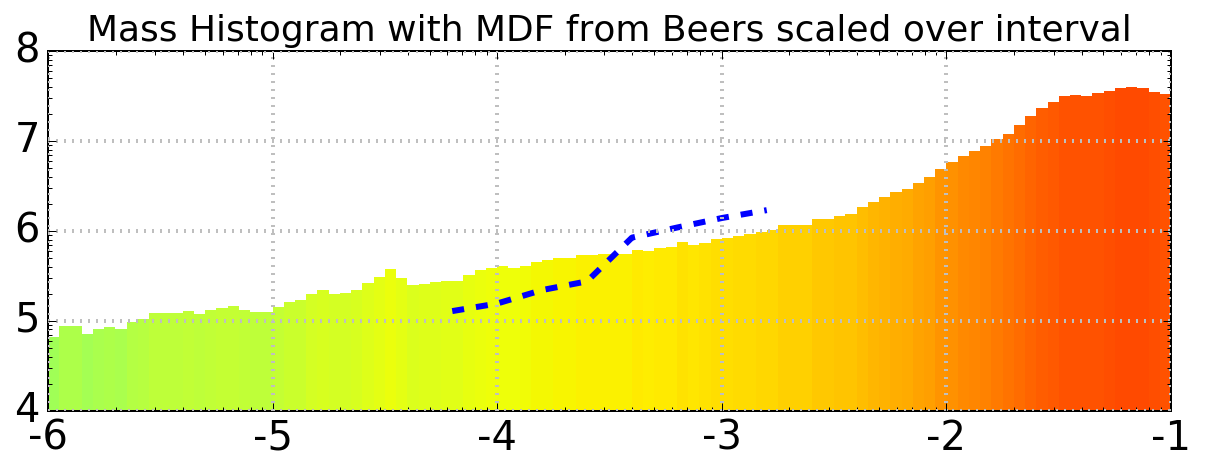

In [34]:
xrange = np.logspace(-9,0,181)
axHistx = plt.axes(rect_2dhist)

labelsize = 20

# Create the histogram and overlay Tim's MDF from the star catalogue
# The value newScaleFor3to4 scales the MDF to the average mass in the
# [Fe/H] range 1e-3 to 1e-4.5 ... which is our plot range.
axHistx.loglog(10**(MDF0Orig[1:,0]), # Need 10** since the values are already log10...
#               MDF0[:,1]/max(MDF0[:,1]) * 10**scaleAt3,ls='--',lw=3) 
               MDF0Orig[1:,1]/np.mean(MDF0Orig[:,1]) * 10**newScaleFor3to4Orig,ls='--',lw=3) 

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([1e-6,1e-1])  # Match the x range on the horiz hist
axHistx.set_ylim([1e4,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e4, 1e5,1e6,1e7,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.xaxis.set_label("[Fe/H")
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_aspect(0.4)
axHistx.set_title("Mass Histogram with MDF from Beers scaled over interval",size=18)


## This is the data from the MDF paper... should be reasonable from -2..-3

In [35]:
AnPlot = np.loadtxt("/Users/earnric/Dropbox/sarmento-paper/MDF from An, Beers paper/TimPaperMDFBins.txt",
                                   skiprows=1)

In [36]:
# Create data points - each entry is (Fe/H, count)
# For data point (x,y), this creates y copies of data point x. Fakes out histogram data IFF you pick the bins correctly
# From MDF paper by 
AnStarsDerived = np.repeat(AnPlot[:,0],AnPlot.astype(int)[:,1])

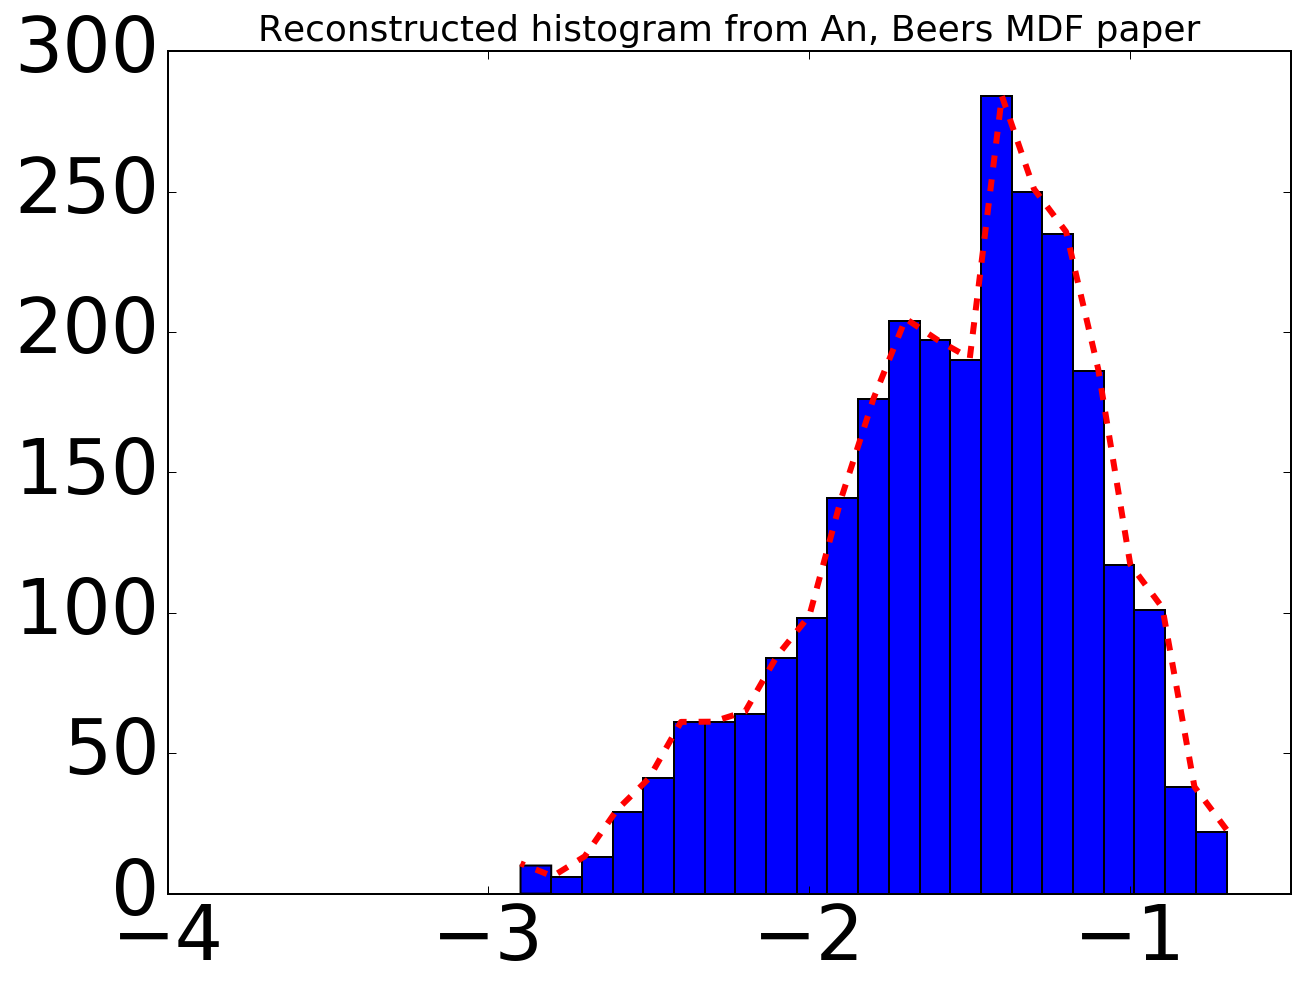

In [37]:
lowZhist = plt.axes(rect_2dhist)
nAnStarsHistRaw,AnStarsBinsRaw,AnStarsPatchesRaw = plt.hist(AnStarsDerived, bins=23)
plt.plot(AnPlot[:,0],AnPlot[:,1],'r--',lw=3)
plt.title("Reconstructed histogram from An, Beers MDF paper",size=18)
lowZhist.xaxis.set_ticks([-4,-3,-2,-1])


In [38]:
anBins=np.arange(-3,0,0.1)
anBins

array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
       -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
       -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1])

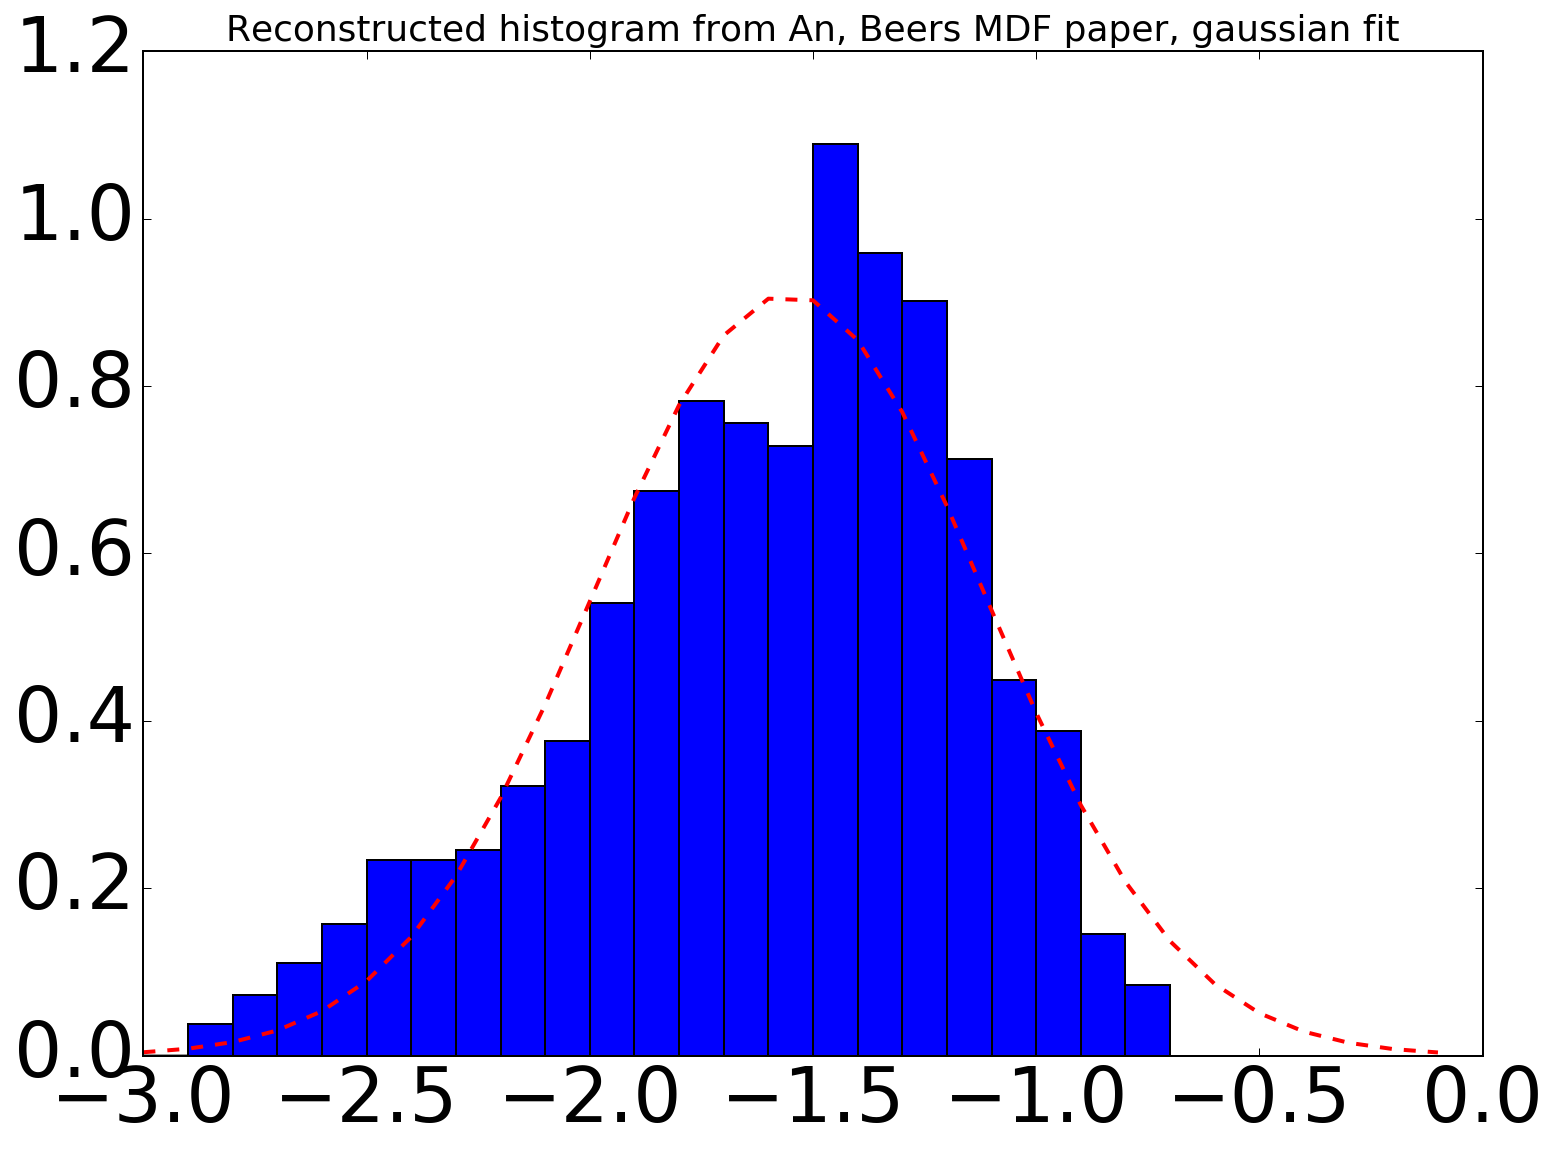

In [39]:
(mu, sigma) = norm.fit(AnStarsDerived)
nAnStarsHist,AnStarsBins,AnStarsPatches = plt.hist(AnStarsDerived, bins=anBins,normed=True)
y = mlab.normpdf( AnStarsBins, mu, sigma)
l = plt.plot(AnStarsBins, y, 'r--', linewidth=2)
plt.title("Reconstructed histogram from An, Beers MDF paper, gaussian fit",size=18)
#l = plt.loglog(10**TimDatabins, y*10**Nnormed[(bins>9.8e-03) & (bins<1.1e-2)], 'r--', linewidth=2)

In [40]:
nAnStarsHist,AnStarsBins,AnStarsPatches = plt.hist(AnStarsDerived, bins=anBins, normed=True)
plt.title("An, Beers MDF paper, Normalized to 1",size=18)
plt.ylim([0,.15])
for item in AnStarsPatches:
    item.set_height(item.get_height()/sum(nAnStarsHist))


In [41]:
AnStarsBins,nAnStarsHist

(array([-3. , -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
        -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
        -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]),
 array([ 0.        ,  0.03834356,  0.07285276,  0.11119632,  0.15720859,
         0.23389571,  0.23389571,  0.24539877,  0.32208589,  0.37576687,
         0.54064417,  0.67484663,  0.78220859,  0.7553681 ,  0.72852761,
         1.08895706,  0.95858896,  0.90107362,  0.71319018,  0.44861963,
         0.38726994,  0.14570552,  0.08435583,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]))

In [42]:
#Just use the points <= -2.0 in the MDF
MDF1 = AnPlot[(AnPlot[:,0] <= -2.0) & (AnPlot[:,0] > -2.9)]
MDF1Raw = AnPlot[(AnPlot[:,0] <= -2.0) & (AnPlot[:,0] > -2.9)]
MDF1Orig = AnPlot[(AnPlot[:,0] <= -2.0) & (AnPlot[:,0] >= -3.0)]

In [43]:
MDF1Raw

array([[ -2.   ,  98.974],
       [ -2.1  ,  84.768],
       [ -2.2  ,  64.846],
       [ -2.3  ,  61.223],
       [ -2.4  ,  61.15 ],
       [ -2.5  ,  41.022],
       [ -2.6  ,  29.772],
       [ -2.7  ,  13.261],
       [ -2.8  ,   6.154]])

In [44]:
MDF1,MDF1Orig,len(MDF1Orig)

(array([[ -2.   ,  98.974],
        [ -2.1  ,  84.768],
        [ -2.2  ,  64.846],
        [ -2.3  ,  61.223],
        [ -2.4  ,  61.15 ],
        [ -2.5  ,  41.022],
        [ -2.6  ,  29.772],
        [ -2.7  ,  13.261],
        [ -2.8  ,   6.154]]), array([[ -2.   ,  98.974],
        [ -2.1  ,  84.768],
        [ -2.2  ,  64.846],
        [ -2.3  ,  61.223],
        [ -2.4  ,  61.15 ],
        [ -2.5  ,  41.022],
        [ -2.6  ,  29.772],
        [ -2.7  ,  13.261],
        [ -2.8  ,   6.154],
        [ -2.9  ,  10.75 ]]), 10)

/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


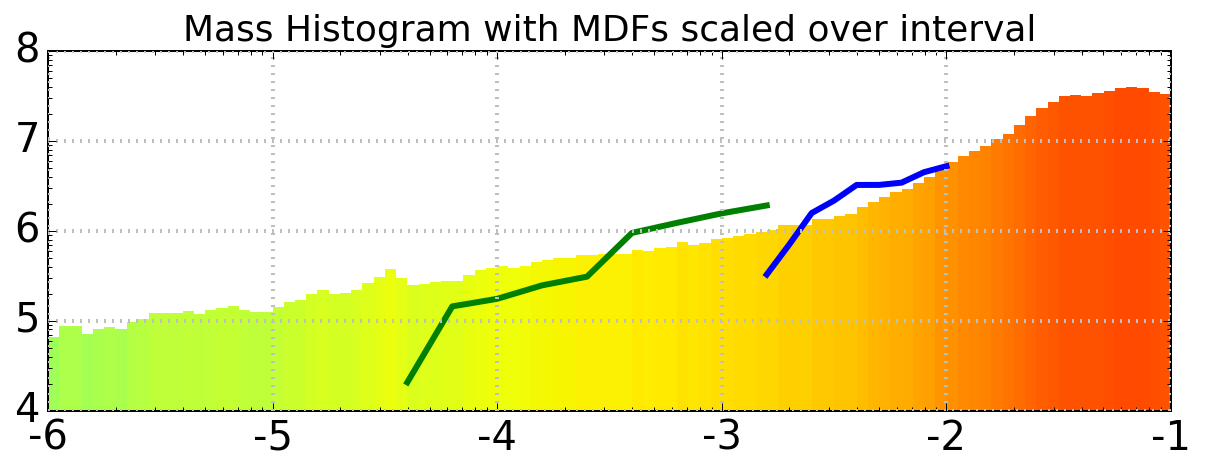

In [45]:
xrange = np.logspace(-9,0,181)
axHistx = plt.axes(rect_2dhist)

labelsize = 20

axHistx.loglog(10**(MDF1[:,0]), # Need 10** since the values are already log10...
#               MDF1[:,1]/max(MDF1[:,1]) * 10**scaleAt2,ls='-',lw=3) 
               MDF1[:,1]/np.mean(MDF1[:,1]) * 10**newScaleFor2to3,ls='-',lw=3) 
axHistx.loglog(10**(MDF0[:,0]), # Need 10** since the values are already log10...
#               MDF0[:,1]/max(MDF0[:,1]) * 10**scaleAt3,ls='-',lw=3) 
               MDF0[:,1]/np.mean(MDF0[:,1]) * 10**newScaleFor3to4,ls='-',lw=3) 

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([1e-6,1e-1])  # Match the x range on the horiz hist
axHistx.set_ylim([1e4,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e4, 1e5,1e6,1e7,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.xaxis.set_label("[Fe/H")
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_aspect(0.4)
axHistx.set_title("Mass Histogram with MDFs scaled over interval",size=18)


In [46]:
MDF0Raw

array([[  -4.4,    2. ],
       [  -4.2,   14. ],
       [  -4. ,   17. ],
       [  -3.8,   24. ],
       [  -3.6,   30. ],
       [  -3.4,   92. ],
       [  -3.2,  119. ],
       [  -3. ,  152. ],
       [  -2.8,  186. ]])

In [47]:
MDF0Raw,MDF1Raw

(array([[  -4.4,    2. ],
        [  -4.2,   14. ],
        [  -4. ,   17. ],
        [  -3.8,   24. ],
        [  -3.6,   30. ],
        [  -3.4,   92. ],
        [  -3.2,  119. ],
        [  -3. ,  152. ],
        [  -2.8,  186. ]]), array([[ -2.   ,  98.974],
        [ -2.1  ,  84.768],
        [ -2.2  ,  64.846],
        [ -2.3  ,  61.223],
        [ -2.4  ,  61.15 ],
        [ -2.5  ,  41.022],
        [ -2.6  ,  29.772],
        [ -2.7  ,  13.261],
        [ -2.8  ,   6.154]]))

In [48]:
(186+13)*10**newScaleFor3to4

145093089.62098396

In [49]:
gc.collect()

1531

In [50]:
# Compute 1-sigma poisson errors.
MDF0_1sigma = np.sqrt(MDF0Raw[:,1])
MDF1_1sigma = np.sqrt(MDF1Raw[:,1])

# Remember to normalize to the mean of the raw y data, not the new error data
MDF0_scaled = np.stack((10**MDF0Raw[:,0],MDF0Raw[:,1]/np.mean(MDF0Raw[:,1]) * 10**newScaleFor3to4),axis=-1)
MDF1_scaled = np.stack((10**MDF1Raw[:,0],MDF1Raw[:,1]/np.mean(MDF1Raw[:,1]) * 10**newScaleFor2to3),axis=-1)

MDF0_upper = MDF0Raw[:,1] + MDF0_1sigma
MDF0_lower = MDF0Raw[:,1] - MDF0_1sigma
MDF1_upper = MDF1Raw[:,1] + MDF1_1sigma
MDF1_lower = MDF1Raw[:,1] - MDF1_1sigma

MDF0_upper_scaled = np.stack((10**MDF0Raw[:,0],MDF0_upper/np.mean(MDF0Raw[:,1]) * 10**newScaleFor3to4),axis=-1) 
MDF0_lower_scaled = np.stack((10**MDF0Raw[:,0],MDF0_lower/np.mean(MDF0Raw[:,1]) * 10**newScaleFor3to4),axis=-1) 
MDF1_upper_scaled = np.stack((10**MDF1Raw[:,0],MDF1_upper/np.mean(MDF1Raw[:,1]) * 10**newScaleFor2to3),axis=-1) 
MDF1_lower_scaled = np.stack((10**MDF1Raw[:,0],MDF1_lower/np.mean(MDF1Raw[:,1]) * 10**newScaleFor2to3),axis=-1) 


/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


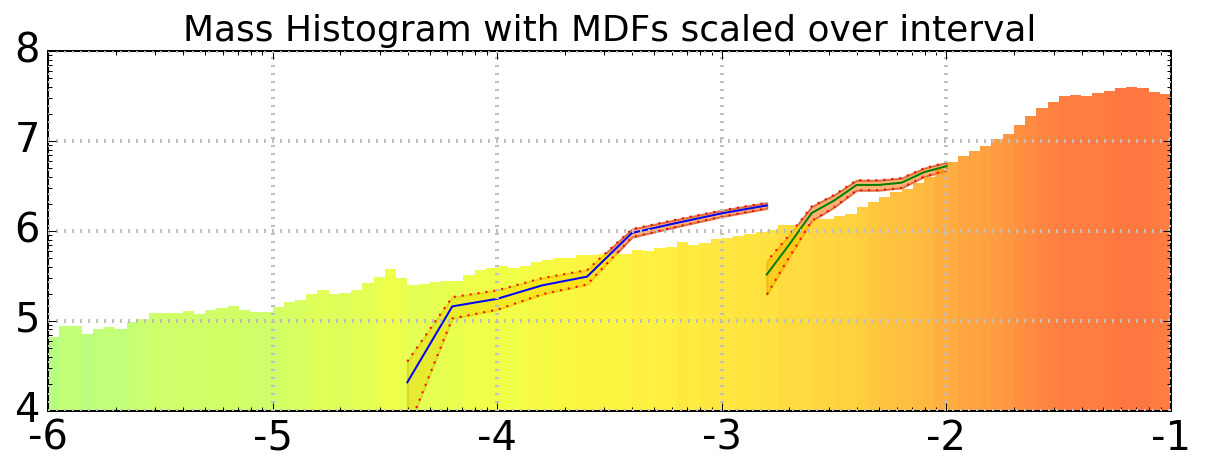

In [51]:
xrange = np.logspace(-9,0,181)
axHistx = plt.axes(rect_2dhist)

labelsize = 20

# axHistx.set_xscale("log", nonposx='clip')
# axHistx.set_yscale("log", nonposy='clip')

axHistx.loglog(MDF0_scaled[:,0], MDF0_scaled[:,1], ls='-', lw=1) 
axHistx.loglog(MDF0_scaled[:,0], MDF0_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF0_scaled[:,0], MDF0_lower_scaled[:,1], ls=':', lw=1, color='r') 

axHistx.loglog(MDF1_scaled[:,0], MDF1_scaled[:,1], ls='-', lw=1) 
axHistx.loglog(MDF1_scaled[:,0], MDF1_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], ls=':', lw=1, color='r') 

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]),alpha=0.75)

normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([1e-6,1e-1])  # Match the x range on the horiz hist
axHistx.set_ylim([1e4,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e4, 1e5,1e6,1e7,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.xaxis.set_label("[Fe/H")
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_aspect(0.4)
axHistx.set_title("Mass Histogram with MDFs scaled over interval",size=18)

axHistx.fill_between(MDF0_scaled[:,0], MDF0_lower_scaled[:,1], MDF0_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

axHistx.fill_between(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], MDF1_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')


### Bins overlap here since one histogram as logspace .1 (upper) and lower uses .2

/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


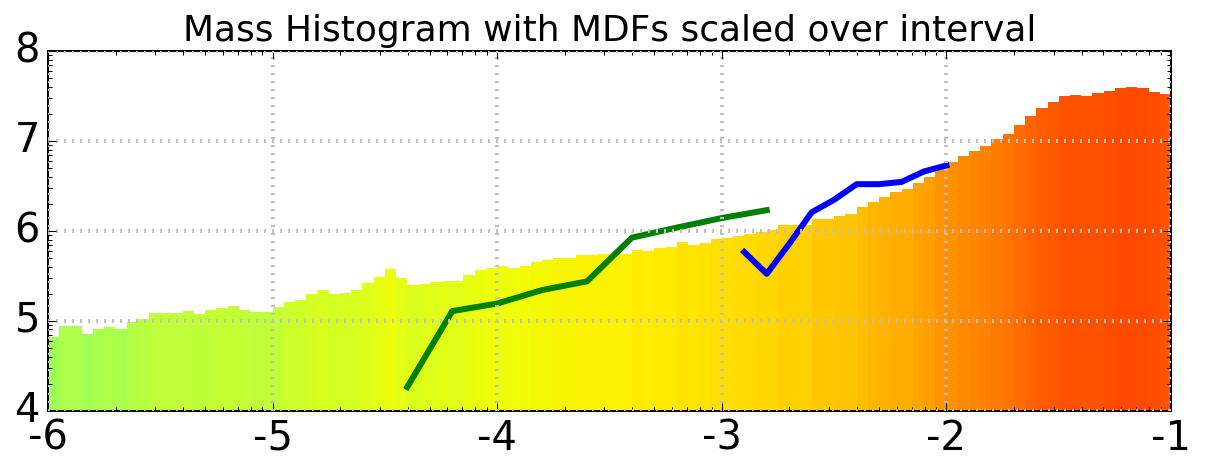

In [52]:
xrange = np.logspace(-9,0,181)
axHistx = plt.axes(rect_2dhist)

labelsize = 20

axHistx.loglog(10**(MDF1Orig[:,0]), # Need 10** since the values are already log10...
#               MDF1[:,1]/max(MDF1[:,1]) * 10**scaleAt2,ls='-',lw=3) 
               MDF1Orig[:,1]/np.mean(MDF1Orig[:,1]) * 10**newScaleFor2to3Orig,ls='-',lw=3) 
axHistx.loglog(10**(MDF0Orig[:,0]), # Need 10** since the values are already log10...
#               MDF0[:,1]/max(MDF0[:,1]) * 10**scaleAt3,ls='-',lw=3) 
               MDF0Orig[:,1]/np.mean(MDF0Orig[:,1]) * 10**newScaleFor3to4Orig,ls='-',lw=3) 

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([1e-6,1e-1])  # Match the x range on the horiz hist
axHistx.set_ylim([1e4,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e4, 1e5,1e6,1e7,1e8])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.xaxis.set_label("[Fe/H")
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_aspect(0.4)
axHistx.set_title("Mass Histogram with MDFs scaled over interval",size=18)


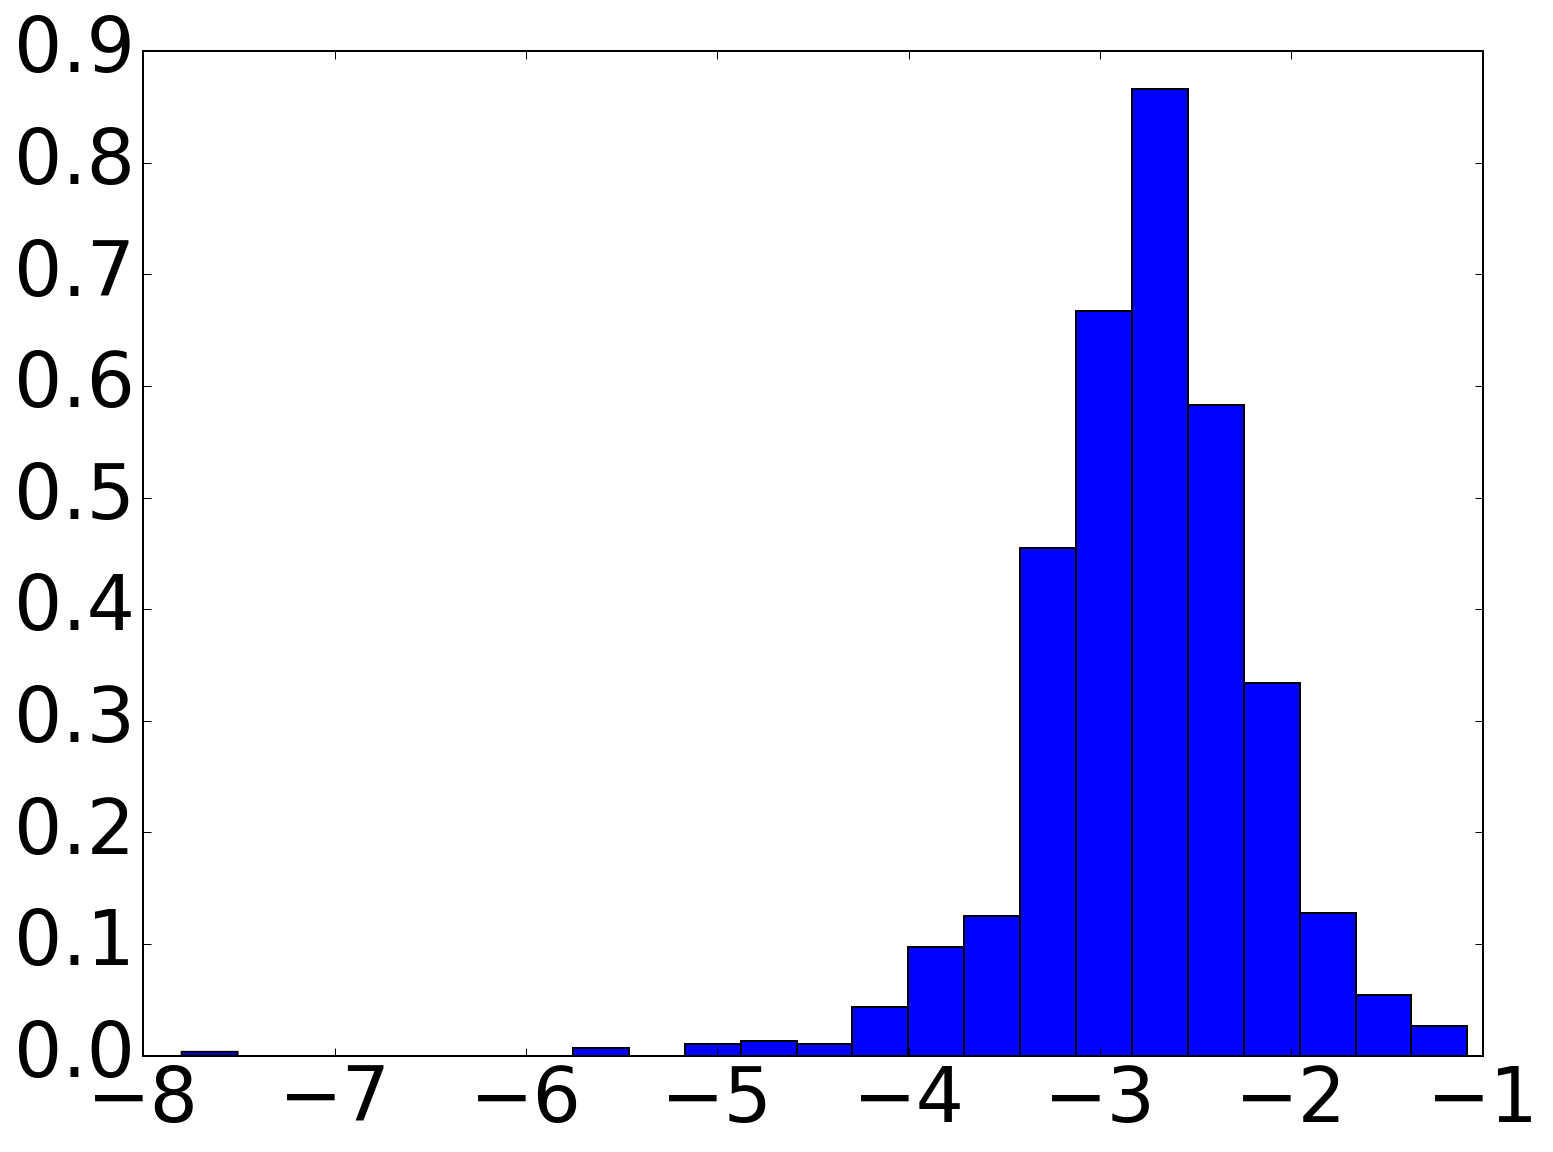

In [53]:
n,BigTimBins,patches = plt.hist(timsStars[timsStars<=3.0], bins=23,normed=True)

# All Plots on one

## Look at bins in out Fe/H histogram range... 

/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:120: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:186: RuntimeWarning: divide by zero encountered in log10


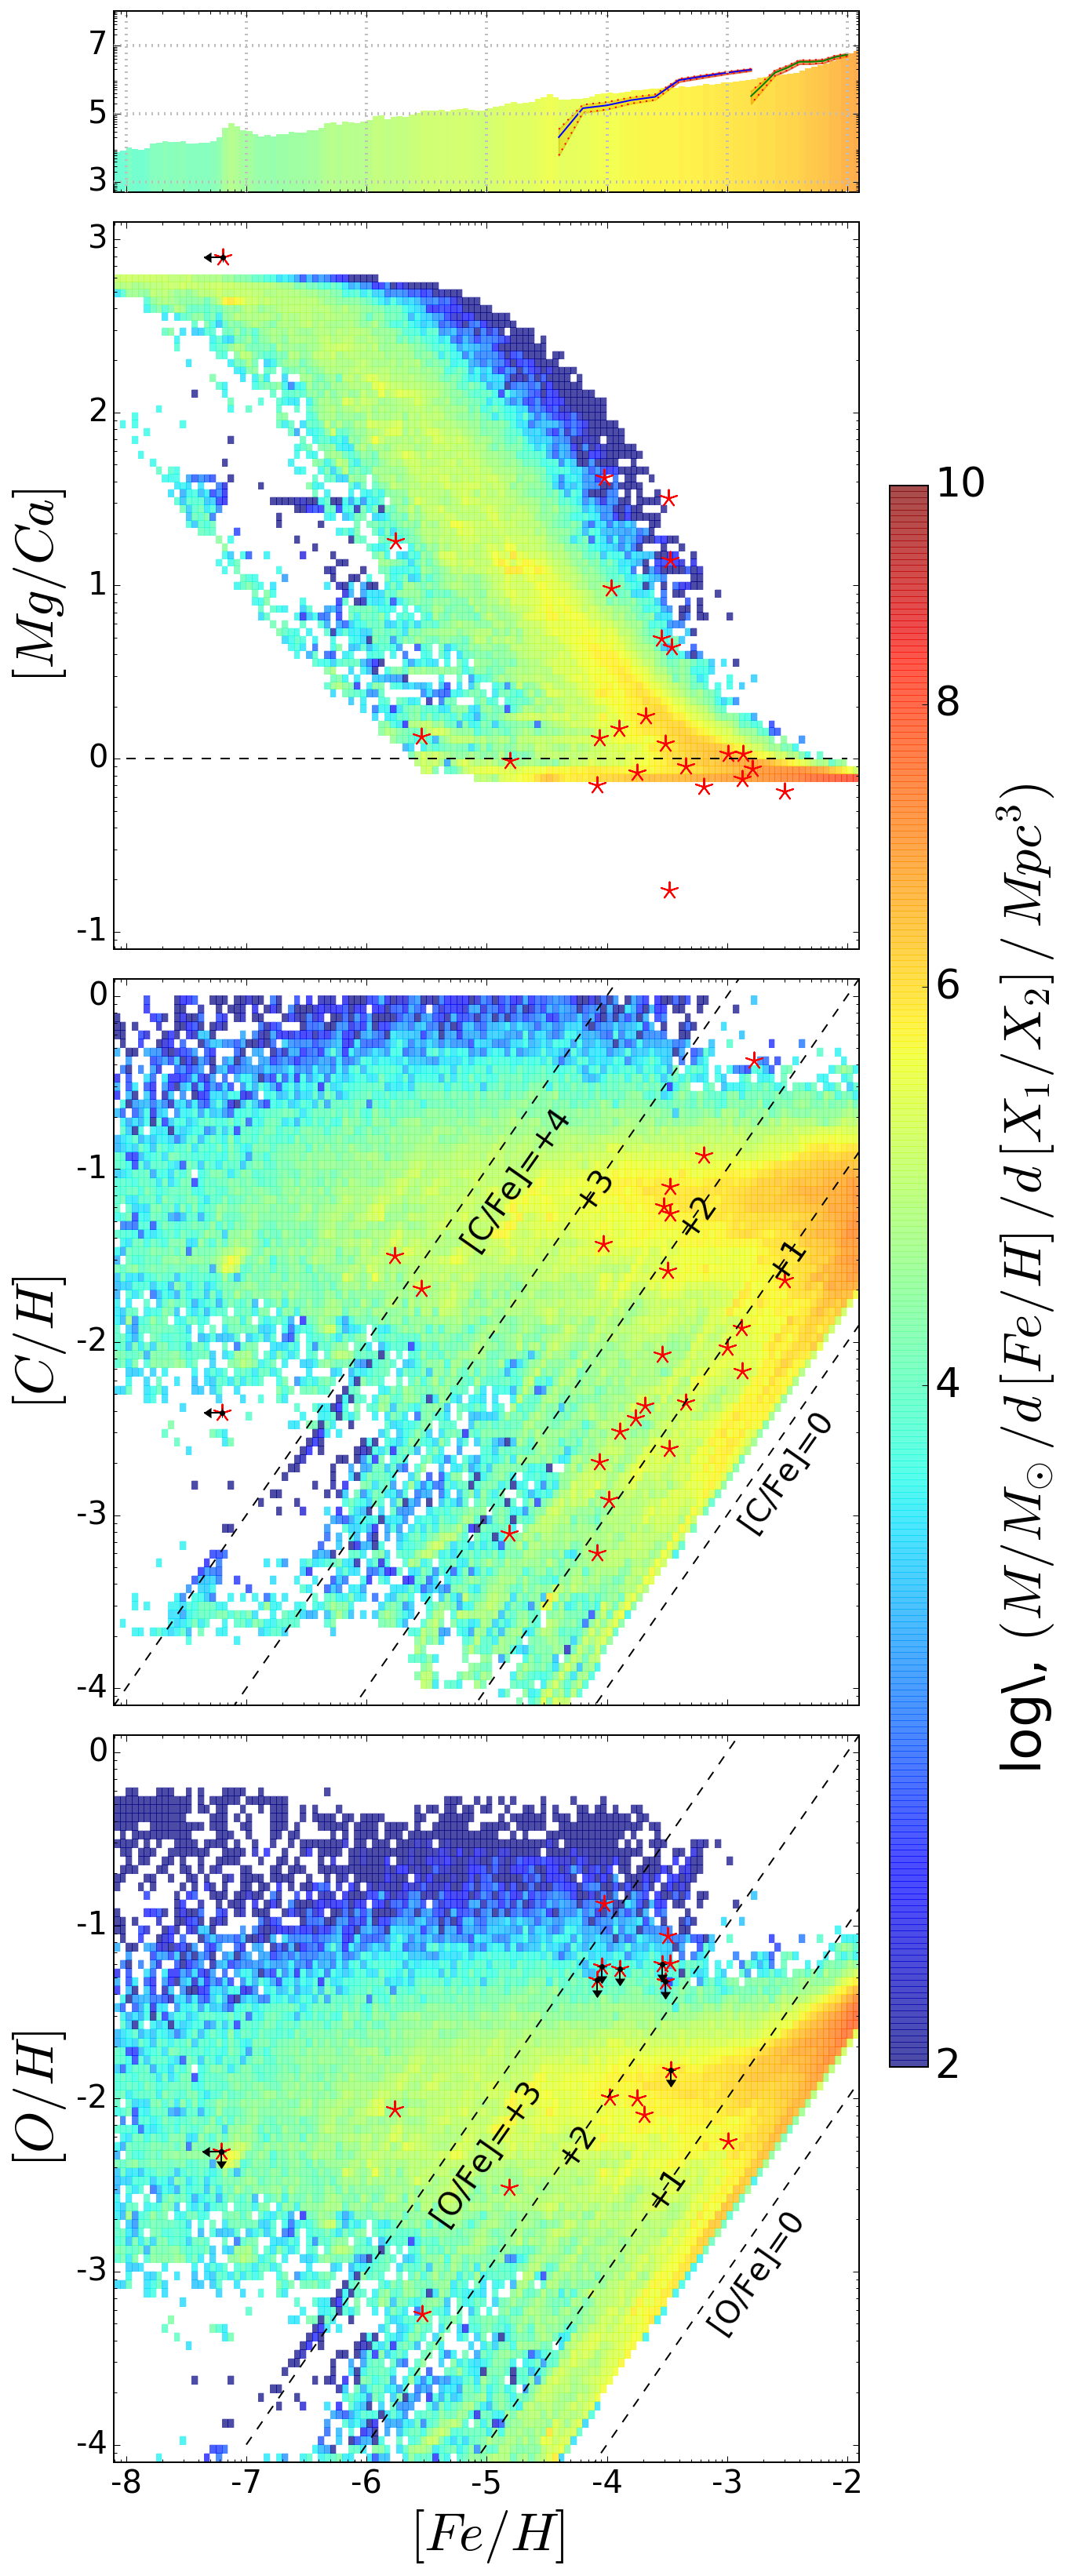

In [54]:
#fig = plt.figure()
fig = plt.figure(figsize=(34, 28))
gs = gridspec.GridSpec(4,1,height_ratios=[1,4,4,4], width_ratios=[4,4,4,4], wspace=0.2, hspace=0.05)
gs.update(left=0.01, right=0.98)
#gs.update(left=0.05, right=0.48, wspace=0.05)
axHistx = plt.subplot(gs[0])
mg = plt.subplot(gs[1])
ca = plt.subplot(gs[2])
ox = plt.subplot(gs[3])

#f, (axHistx, mg, ca, ox) = plt.subplots(4, sharex=True, height_ratios=[4,1] )

nullfmt = NullFormatter()

xrange = np.logspace(-9,0,181)
yrange = np.logspace(-4,4,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

histMax = 8
rotAngle = 55.0

#
# We need to generate bins first, but we need to generate these plots 'first' ... run twice.
#
axHistx.loglog(MDF0_scaled[:,0], MDF0_scaled[:,1], ls='-', lw=1) 
axHistx.loglog(MDF0_scaled[:,0], MDF0_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF0_scaled[:,0], MDF0_lower_scaled[:,1], ls=':', lw=1, color='r') 

axHistx.loglog(MDF1_scaled[:,0], MDF1_scaled[:,1], ls='-', lw=1) 
axHistx.loglog(MDF1_scaled[:,0], MDF1_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], ls=':', lw=1, color='r') 


# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none', alpha=0.70,
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([10**minX,10**maxX])
axHistx.set_ylim([10**2.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e3, 1e5, 1e7])      # 1D Histogram tick marks
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.yaxis.set_label("") # Use integers for ticks


axHistx.fill_between(MDF0_scaled[:,0], MDF0_lower_scaled[:,1], MDF0_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

axHistx.fill_between(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], MDF1_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')


# Plot [Mg/Ca]
mg.tick_params(axis='y', labelsize=labelsize)
mg.set_xlabel("", size=34) # NO LABEL ON X
mg.set_ylabel("$"+yLabel+"$", size=34)
mg.set_xlim([10**minX,10**maxX])
mg.set_ylim([10**minY,10**maxY])
mg.set_xscale('log')
mg.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

###
## Plot [Mg/Ca]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cmg = (mg.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

mg.xaxis.set_major_formatter(nullfmt)
mg.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
mg.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
mg.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

cfeZero,  = mg.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

##
## [C/H]
##
yrange = np.logspace(-9,0,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ca.tick_params(axis='x', labelsize=labelsize)
ca.tick_params(axis='y', labelsize=labelsize)
ca.set_xlabel("", size=34) # NO LABEL ON X
ca.set_ylabel("$"+yLabel+"$", size=34)
ca.set_xlim([10**minX,10**maxX])
ca.set_ylim([10**minY,10**maxY])
ca.set_xscale('log')
ca.set_yscale('log')

###
## Plot [C/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cca = (ca.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ca.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ca.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ca.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeThree,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ca.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeFour,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ca.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=rotAngle)

ca.xaxis.set_major_formatter(nullfmt)
ca.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
ca.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ca.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))


##
## [O/H]
##
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)


minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

ox.tick_params(axis='x', labelsize=labelsize)
ox.tick_params(axis='y', labelsize=labelsize)
ox.set_xlabel("$[Fe/H]$", size=34)
ox.set_ylabel("$"+yLabel+"$", size=34)
ox.set_xlim([10**minX,10**maxX])
ox.set_ylim([10**minY,10**maxY])
ox.set_xscale('log')
ox.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ox.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ox.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ox.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeThree, = ox.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ox.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=rotAngle ) 

ox.xaxis.set_major_formatter(custom_formatter)
ox.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
###
## Plot [O/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0

## Create a plot of the binned data, use a fixed lognormal scale
cox = (ox.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

ox.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ox.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ox.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))

#
# Add a colorbar
#
cbarticks = [2,4,6, 8, cbarMax]
cax, kw = mpl.colorbar.make_axes([ax for ax in [axHistx, mg, ca, ox]], location='right')
#cax.set_yticklabels(cbarticks, size=26)
#cax.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$ ", size=34)
cbar = plt.colorbar(cox, cax=cax, ticks=cbarticks, **kw)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log\, $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[X_1/X_2]\, /\, Mpc^{3})$ ", size=34)
cbar.ax.set_aspect('auto')
cbar.ax.set_position((0.212, 0.25, 0.01, 0.5))
plt.savefig("metals_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')
plt.show()


/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:115: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:181: RuntimeWarning: divide by zero encountered in log10


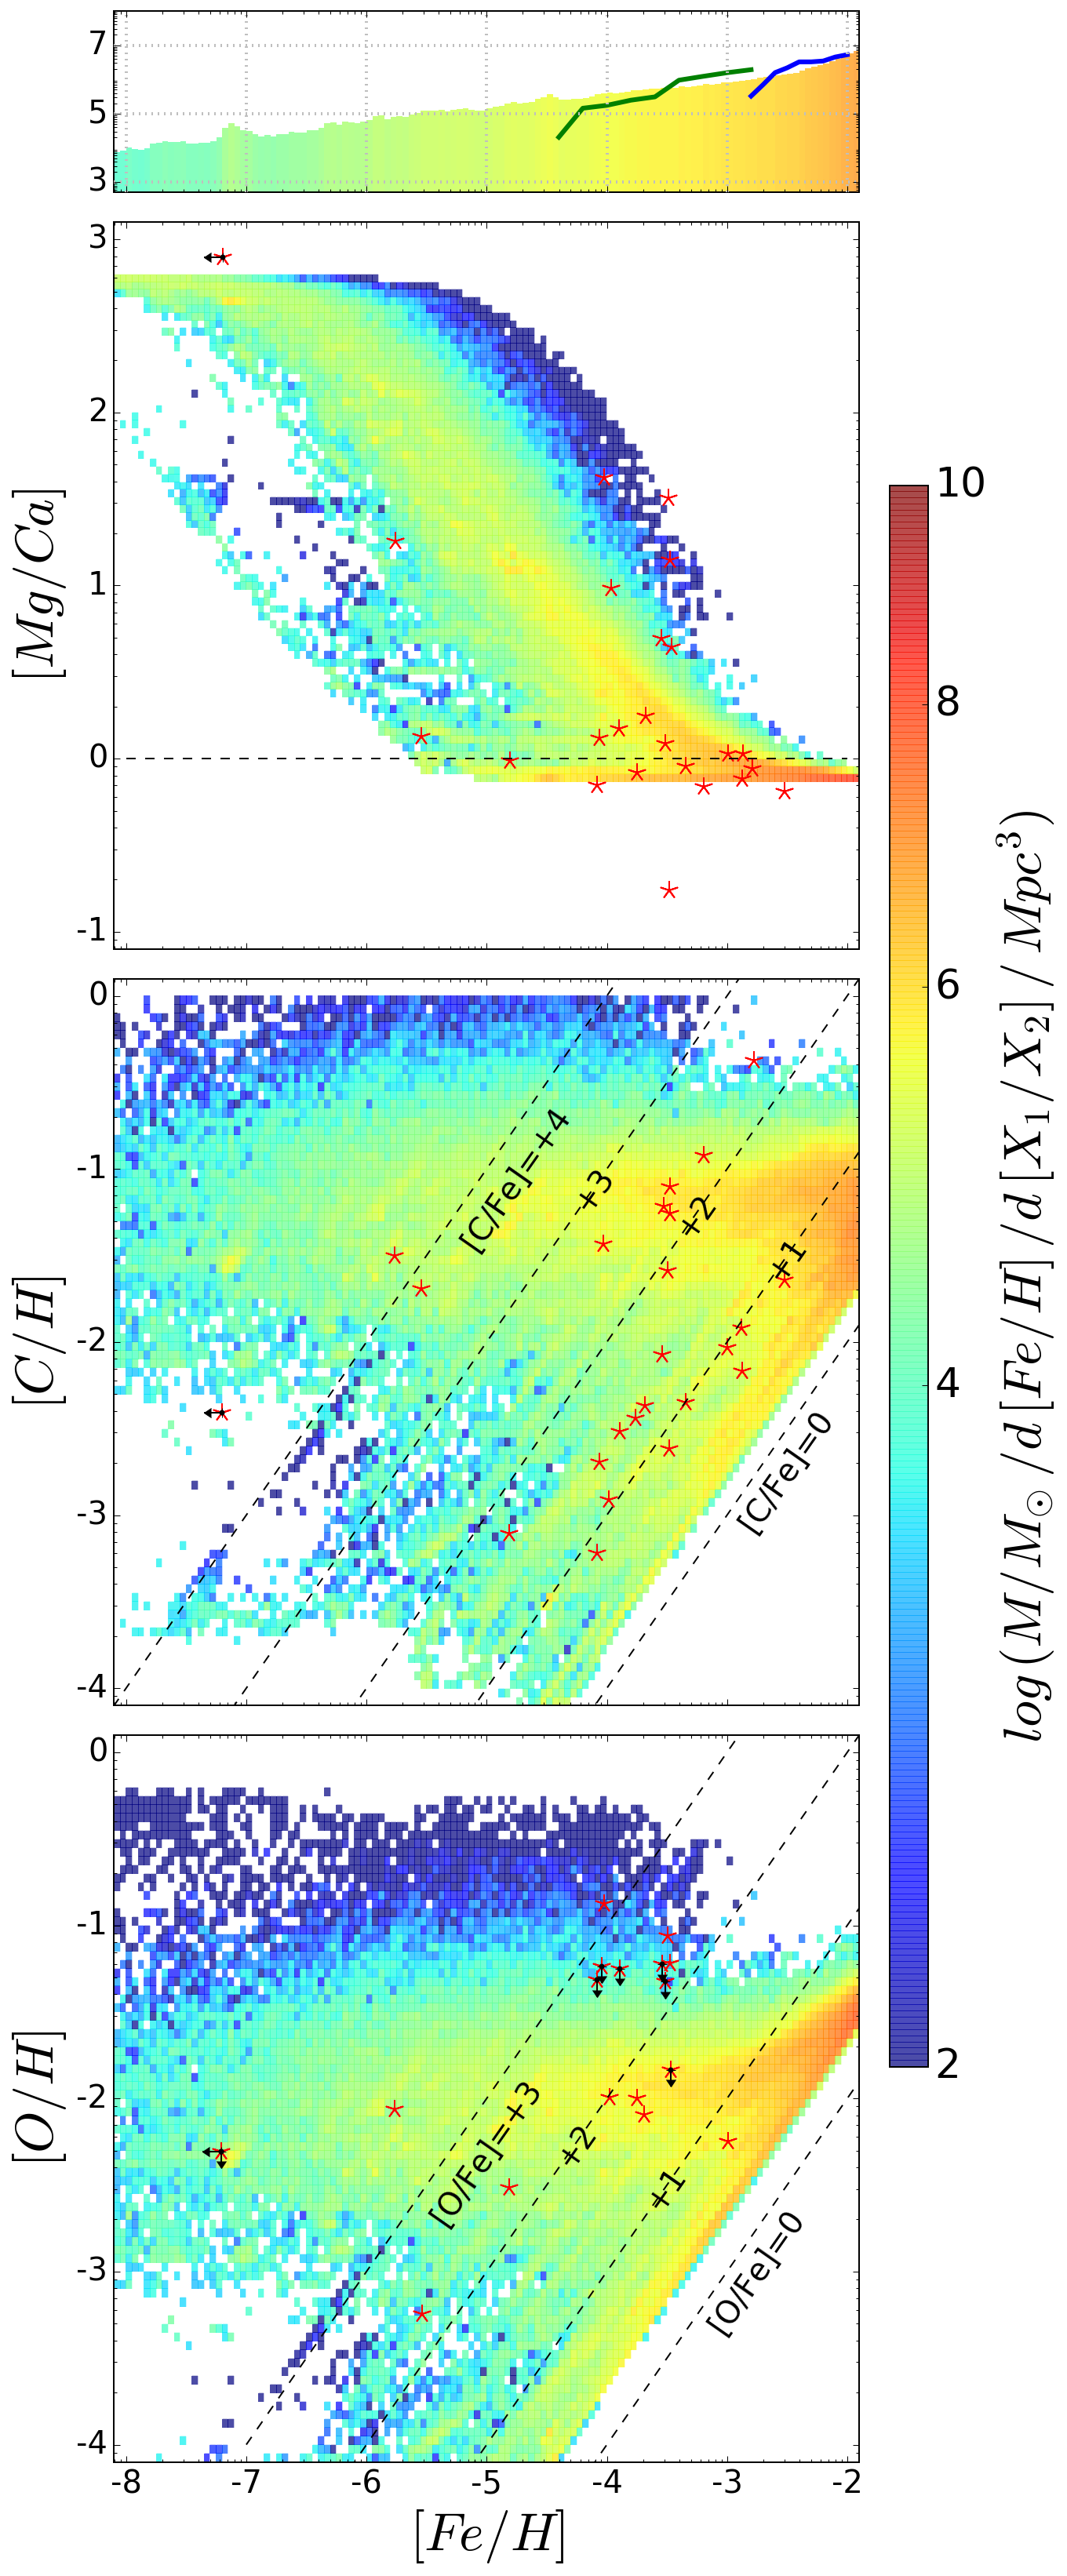

In [70]:
#fig = plt.figure()
fig = plt.figure(figsize=(34, 28))
gs = gridspec.GridSpec(4,1,height_ratios=[1,4,4,4], width_ratios=[4,4,4,4], wspace=0.2, hspace=0.05)
gs.update(left=0.01, right=0.98)
#gs.update(left=0.05, right=0.48, wspace=0.05)
axHistx = plt.subplot(gs[0])
mg = plt.subplot(gs[1])
ca = plt.subplot(gs[2])
ox = plt.subplot(gs[3])

#f, (axHistx, mg, ca, ox) = plt.subplots(4, sharex=True, height_ratios=[4,1] )

nullfmt = NullFormatter()

xrange = np.logspace(-9,0,181)
yrange = np.logspace(-4,4,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

histMax = 8
rotAngle = 55.0

# ##########################################
# We need to generate bins first, but we need to generate these plots 'first' ... run twice.
# ##########################################
#
# We need to generate bins first, but we need to generate these plots 'first' ... run twice.
#
axHistx.loglog(10**(MDF1[:,0]), # Need 10** since the values are already log10...
#               MDF1[:,1]/max(MDF1[:,1]) * 10**scaleAt2,ls='-',lw=3) 
               MDF1[:,1]/np.mean(MDF1[:,1]) * 10**newScaleFor2to3,ls='-',lw=3) 
axHistx.loglog(10**(MDF0[:,0]), # Need 10** since the values are already log10...
#               MDF0[:,1]/max(MDF0[:,1]) * 10**scaleAt3,ls='-',lw=3) 
               MDF0[:,1]/np.mean(MDF0[:,1]) * 10**newScaleFor3to4,ls='-',lw=3) 

# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none', alpha=0.70,
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([10**minX,10**maxX])
axHistx.set_ylim([10**2.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.yaxis.set_ticks([1e3, 1e5, 1e7])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
#axHistx.yaxis.set_label_position("right")
#axHistx.set_ylabel("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$",size=24) # Use integers for ticks


# Plot [Mg/Ca]
mg.tick_params(axis='y', labelsize=labelsize)
mg.set_xlabel("", size=34) # NO LABEL ON X
mg.set_ylabel("$"+yLabel+"$", size=34)
mg.set_xlim([10**minX,10**maxX])
mg.set_ylim([10**minY,10**maxY])
mg.set_xscale('log')
mg.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)

###
## Plot [Mg/Ca]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cmg = (mg.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

mg.xaxis.set_major_formatter(nullfmt)
mg.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
mg.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
mg.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

cfeZero,  = mg.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

##
## [C/H]
##
yrange = np.logspace(-9,0,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ca.tick_params(axis='x', labelsize=labelsize)
ca.tick_params(axis='y', labelsize=labelsize)
ca.set_xlabel("", size=34) # NO LABEL ON X
ca.set_ylabel("$"+yLabel+"$", size=34)
ca.set_xlim([10**minX,10**maxX])
ca.set_ylim([10**minY,10**maxY])
ca.set_xscale('log')
ca.set_yscale('log')

###
## Plot [C/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cca = (ca.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ca.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ca.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ca.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeThree,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ca.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeFour,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ca.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=rotAngle)

ca.xaxis.set_major_formatter(nullfmt)
ca.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
ca.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ca.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))


##
## [O/H]
##
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)


minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

ox.tick_params(axis='x', labelsize=labelsize)
ox.tick_params(axis='y', labelsize=labelsize)
ox.set_xlabel("$[Fe/H]$", size=34)
ox.set_ylabel("$"+yLabel+"$", size=34)
ox.set_xlim([10**minX,10**maxX])
ox.set_ylim([10**minY,10**maxY])
ox.set_xscale('log')
ox.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ox.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ox.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ox.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeThree, = ox.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ox.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=rotAngle ) 

ox.xaxis.set_major_formatter(custom_formatter)
ox.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
###
## Plot [O/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0

## Create a plot of the binned data, use a fixed lognormal scale
cox = (ox.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

ox.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ox.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ox.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))

#
# Add a colorbar
#
cbarticks = [2,4,6, 8, cbarMax]
cax, kw = mpl.colorbar.make_axes([ax for ax in [axHistx, mg, ca, ox]], location='right')
#cax.set_yticklabels(cbarticks, size=26)
#cax.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$ ", size=34)
cbar = plt.colorbar(cox, cax=cax, ticks=cbarticks, **kw)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, / d\,[X_1/X_2]\, /\, Mpc^{3})$", size=34)
cbar.ax.set_aspect('auto')
cbar.ax.set_position((0.212, 0.25, 0.01, 0.5))
#plt.savefig("metals_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')
plt.show()


# Rearrange

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


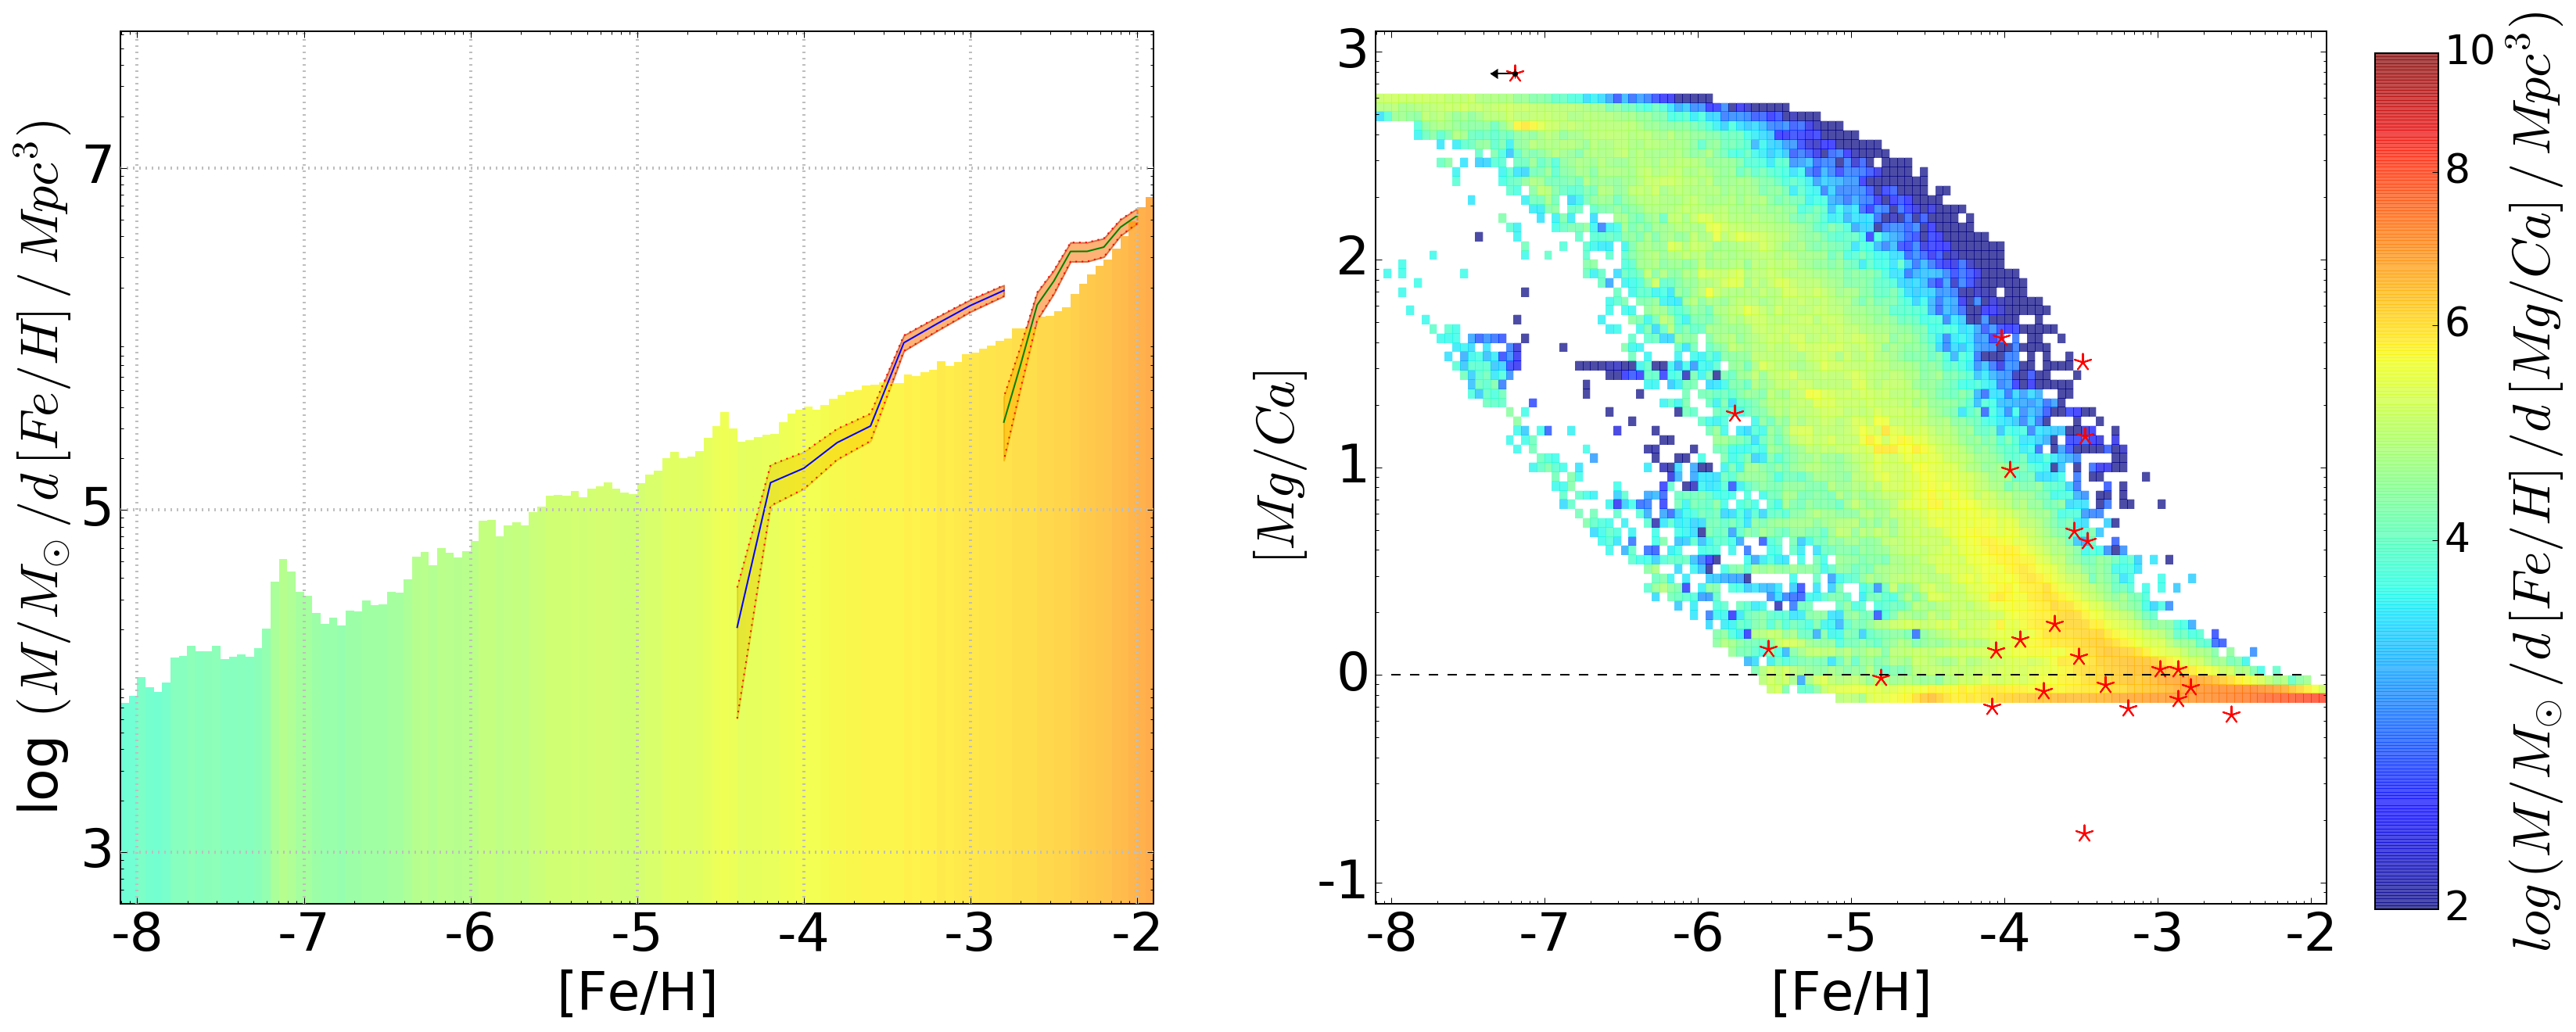

In [60]:
#fig = plt.figure()
fig = plt.figure(figsize=(28, 20))
gs = gridspec.GridSpec(1,2,height_ratios=[1,1], width_ratios=[1,1.15], wspace=0.2, hspace=0.05)
#gs.update(left=0.01, right=0.98)
axHistx = plt.subplot(gs[0])
mg      = plt.subplot(gs[1])

#f, (axHistx, mg, ca, ox) = plt.subplots(4, sharex=True, height_ratios=[4,1] )

nullfmt = NullFormatter()

xrange = np.logspace(-9,0,181)
yrange = np.logspace(-4,4,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, 
                                   weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                   bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

histMax = 7.8
rotAngle = 55.0

#
# We need to generate bins first, but we need to generate these plots 'first' ... run twice.
#
axHistx.loglog(MDF0_scaled[:,0], MDF0_scaled[:,1], ls='-', lw=1) 
axHistx.loglog(MDF0_scaled[:,0], MDF0_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF0_scaled[:,0], MDF0_lower_scaled[:,1], ls=':', lw=1, color='r') 

axHistx.loglog(MDF1_scaled[:,0], MDF1_scaled[:,1], ls='-', lw=1) 
axHistx.loglog(MDF1_scaled[:,0], MDF1_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], ls=':', lw=1, color='r') 


# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none', alpha=0.70,
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([10**minX,10**maxX])
axHistx.set_ylim([10**2.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.tick_params(axis='x', labelsize=labelsize)
#ox.tick_params(axis='y', labelsize=labelsize)
axHistx.xaxis.set_ticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
axHistx.yaxis.set_ticks([1e3, 1e5, 1e7])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_xlabel("[Fe/H]", size=34) # NO LABEL ON X
axHistx.set_ylabel("log $(M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$", size=34)
#axHistx.yaxis.set_label_position("right")
#axHistx.set_ylabel("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$",size=24) # Use integers for ticks

axHistx.fill_between(MDF0_scaled[:,0], MDF0_lower_scaled[:,1], MDF0_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

axHistx.fill_between(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], MDF1_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

# Plot [Mg/Ca]
mg.tick_params(axis='x', labelsize=labelsize)
mg.tick_params(axis='y', labelsize=labelsize)
mg.set_xlabel("[Fe/H]", size=labelsize) # NO LABEL ON X
mg.set_ylabel("$"+yLabel+"$", size=34)
mg.set_xlim([10**minX,10**maxX])
mg.set_ylim([10**minY,10**maxY])
mg.set_xscale('log')
mg.set_yscale('log')

mg.xaxis.set_major_formatter(custom_formatter)
mg.yaxis.set_major_formatter(custom_formatter)

###
## Plot [Mg/Ca]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cmg = (mg.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

# Add Keller CEMP star points
mg.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
mg.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

cfeZero,  = mg.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

#
# Add a colorbar
#
cbarticks = [2,4,6, 8, cbarMax]
cax, kw = mpl.colorbar.make_axes([ax for ax in [mg]], location='right')
cbar = plt.colorbar(cox, cax=cax, ticks=cbarticks, **kw)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, / d\,[Mg/Ca]\, /\, Mpc^{3})$", size=34)
cbar.ax.set_aspect('auto')
cbar.ax.set_position((0.84, 0.51, 0.02, 0.38))

plt.savefig("hist_MgCa_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')
plt.show()


/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:140: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:206: RuntimeWarning: divide by zero encountered in log10


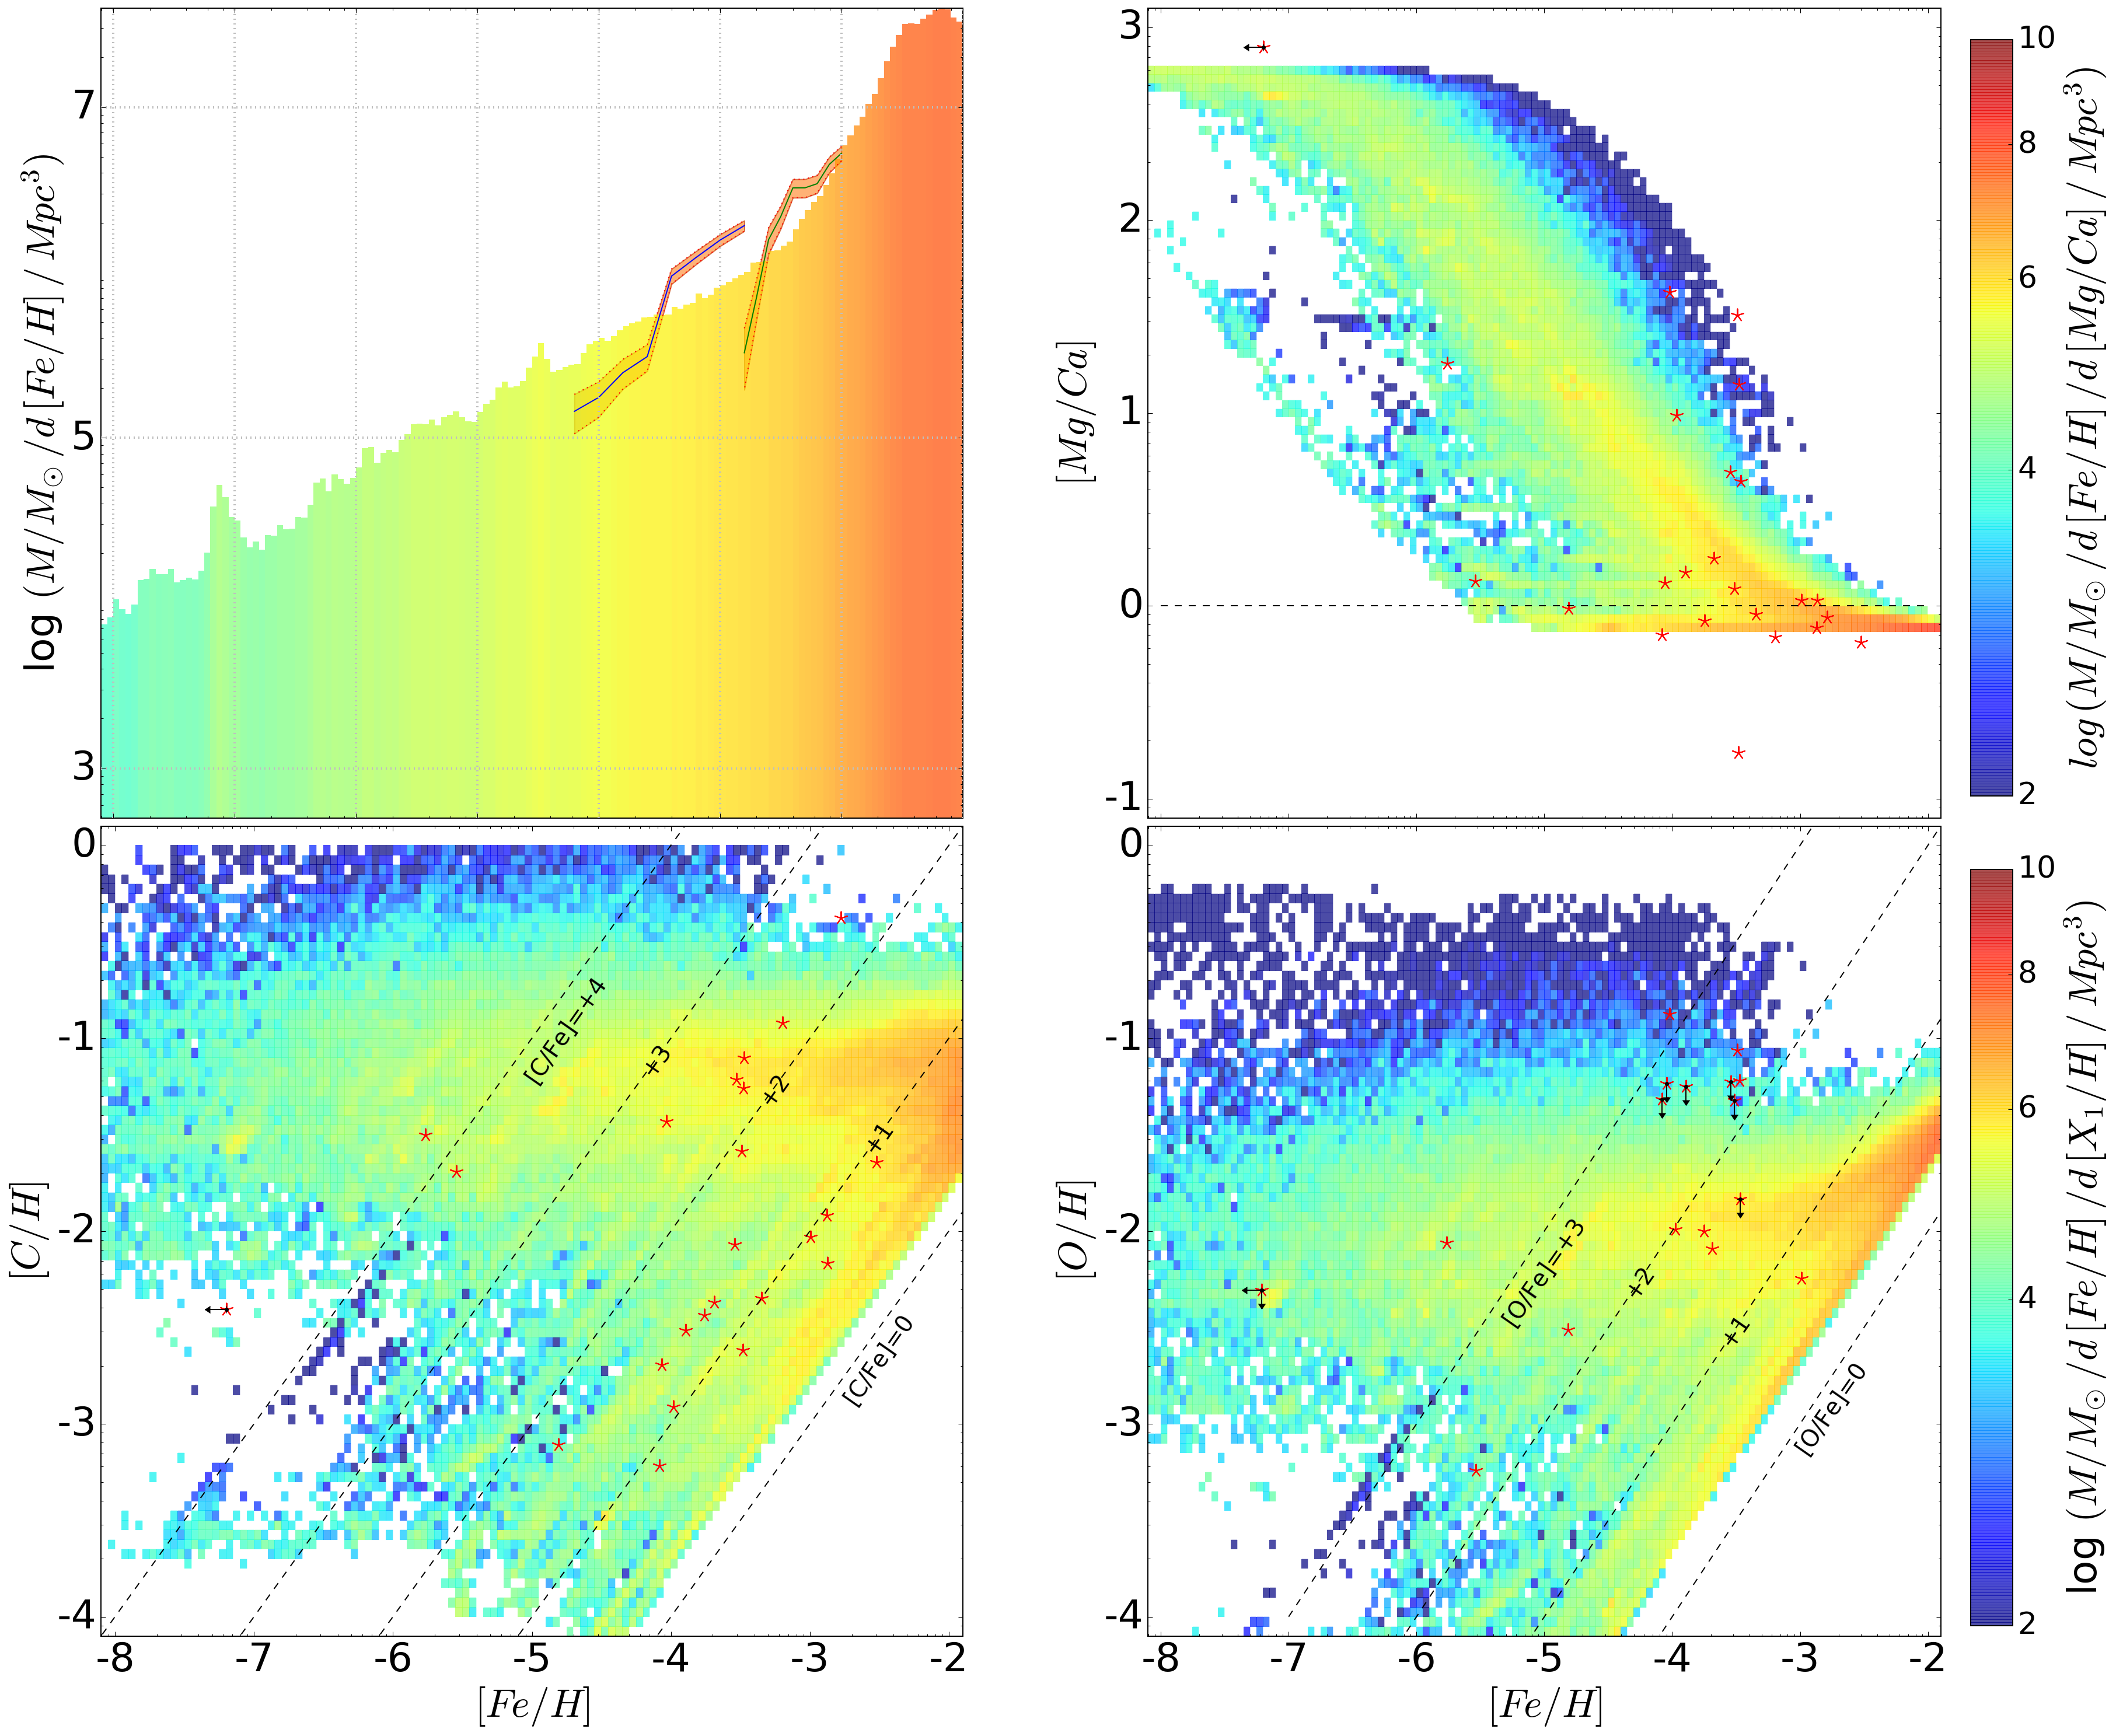

In [58]:
#fig = plt.figure()
fig = plt.figure(figsize=(25, 25))
gs = gridspec.GridSpec(2,2,height_ratios=[1,1], width_ratios=[1,1.15], wspace=0.2, hspace=0.01)
gs.update(left=0.01, right=0.98)
#gs.update(left=0.05, right=0.48, wspace=0.05)
axHistx = plt.subplot(gs[0])
mg      = plt.subplot(gs[1])
ca = plt.subplot(gs[2])
ox = plt.subplot(gs[3])

#f, (axHistx, mg, ca, ox) = plt.subplots(4, sharex=True, height_ratios=[4,1] )

nullfmt = NullFormatter()

xrange = np.logspace(-9,0,181)
yrange = np.logspace(-4,4,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[Mg/Ca]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, 
                                   weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                   bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

histMax = 7.6
rotAngle = 55.0

#
# We need to generate bins first, but we need to generate these plots 'first' ... run twice.
#
axHistx.plot(MDF0_scaled[1:,0], MDF0_scaled[1:,1], ls='-', lw=1) 
axHistx.plot(MDF0_scaled[1:,0], MDF0_upper_scaled[1:,1], ls=':', lw=1, color='r') 
axHistx.plot(MDF0_scaled[1:,0], MDF0_lower_scaled[1:,1], ls=':', lw=1, color='r') 

axHistx.plot(MDF1_scaled[:,0], MDF1_scaled[:,1], ls='-', lw=1) 
axHistx.plot(MDF1_scaled[:,0], MDF1_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.plot(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], ls=':', lw=1, color='r') 


# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none', alpha=0.70,
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
axHistx.set_yscale("log")
colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([10**minX,10**maxX])
axHistx.set_ylim([10**2.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.tick_params(axis='x', labelsize=labelsize)
#ox.tick_params(axis='y', labelsize=labelsize)
axHistx.xaxis.set_ticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
axHistx.yaxis.set_ticks([1e3, 1e5, 1e7])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_xlabel("[Fe/H]", size=34) # NO LABEL ON X
axHistx.set_ylabel("log $(M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$", size=34)
#axHistx.yaxis.set_label_position("right")
#axHistx.set_ylabel("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$",size=24) # Use integers for ticks

axHistx.fill_between(MDF0_scaled[1:,0], MDF0_lower_scaled[1:,1], MDF0_upper_scaled[1:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

axHistx.fill_between(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], MDF1_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

# Plot [Mg/Ca]
mg.tick_params(axis='x', labelsize=labelsize)
mg.tick_params(axis='y', labelsize=labelsize)
mg.set_xlabel("[Fe/H]", size=labelsize) # NO LABEL ON X
mg.set_ylabel("$"+yLabel+"$", size=34)
mg.set_xlim([10**minX,10**maxX])
mg.set_ylim([10**minY,10**maxY])
mg.set_xscale('log')
mg.set_yscale('log')

mg.xaxis.set_major_formatter(nullfmt)
mg.yaxis.set_major_formatter(custom_formatter)

###
## Plot [Mg/Ca]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cmg = (mg.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

# Add Keller CEMP star points
mg.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**MgCaFeH[0,0], xuplims=True)
mg.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=120, c="r" ,marker=(5,2))

cfeZero,  = mg.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

#
# Add a colorbar
#
cbarticks = [2,4,6, 8, cbarMax]
cax, kw = mpl.colorbar.make_axes([ax for ax in [mg]], location='right')
cbar = plt.colorbar(cmg, cax=cax, ticks=cbarticks, **kw)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, / d\,[Mg/Ca]\, /\, Mpc^{3})$", size=34)
cbar.ax.set_aspect('auto')
cbar.ax.set_position((0.9, 0.525, 0.02, 0.36))


xrange = np.logspace(-9,0,181)
yrange = np.logspace(-9,0,181)

##
## [C/H]
##
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ca.tick_params(axis='x', labelsize=labelsize)
ca.tick_params(axis='y', labelsize=labelsize)
ca.set_xlabel("$[Fe/H]$", size=34)
ca.set_ylabel("$"+yLabel+"$", size=34)
ca.set_xlim([10**minX,10**maxX])
ca.set_ylim([10**minY,10**maxY])
ca.set_xscale('log')
ca.set_yscale('log')

###
## Plot [C/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cca = (ca.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ca.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ca.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ca.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeThree,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ca.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeFour,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ca.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=rotAngle)

ca.xaxis.set_major_formatter(custom_formatter)
ca.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
ca.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**CHFeH[0,0], xuplims=True)
ca.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=120, c="r" ,marker=(5,2))


##
## [O/H]
##
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)


minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

ox.tick_params(axis='x', labelsize=labelsize)
ox.tick_params(axis='y', labelsize=labelsize)
ox.set_xlabel("$[Fe/H]$", size=34)
ox.set_ylabel("$"+yLabel+"$", size=34)
ox.set_xlim([10**minX,10**maxX])
ox.set_ylim([10**minY,10**maxY])
ox.set_xscale('log')
ox.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ox.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ox.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ox.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeThree, = ox.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ox.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=rotAngle ) 

ox.xaxis.set_major_formatter(custom_formatter)
ox.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
###
## Plot [O/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0

## Create a plot of the binned data, use a fixed lognormal scale
cox = (ox.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

ox.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', 
                  yerr=0.2*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ox.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', 
                  xerr=3e-1*10**OHFeH[0,0], xuplims=True)
ox.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=120, c="r" ,marker=(5,2))

#
# Add a colorbar
#
cbarticks = [2,4,6, 8, cbarMax]
cax, kw = mpl.colorbar.make_axes([ax for ax in [ox]], location='right')
#cax.set_yticklabels(cbarticks, size=26)
#cax.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$ ", size=34)
cbar = plt.colorbar(cox, cax=cax, ticks=cbarticks, **kw)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[X_1/H]\, /\, Mpc^{3})$", size=34)
cbar.ax.set_aspect('auto')
cbar.ax.set_position((0.9, 0.13, 0.02, 0.36))
plt.savefig("metals_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')
plt.show()


/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:140: RuntimeWarning: divide by zero encountered in log10
/Users/earnric/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:206: RuntimeWarning: divide by zero encountered in log10


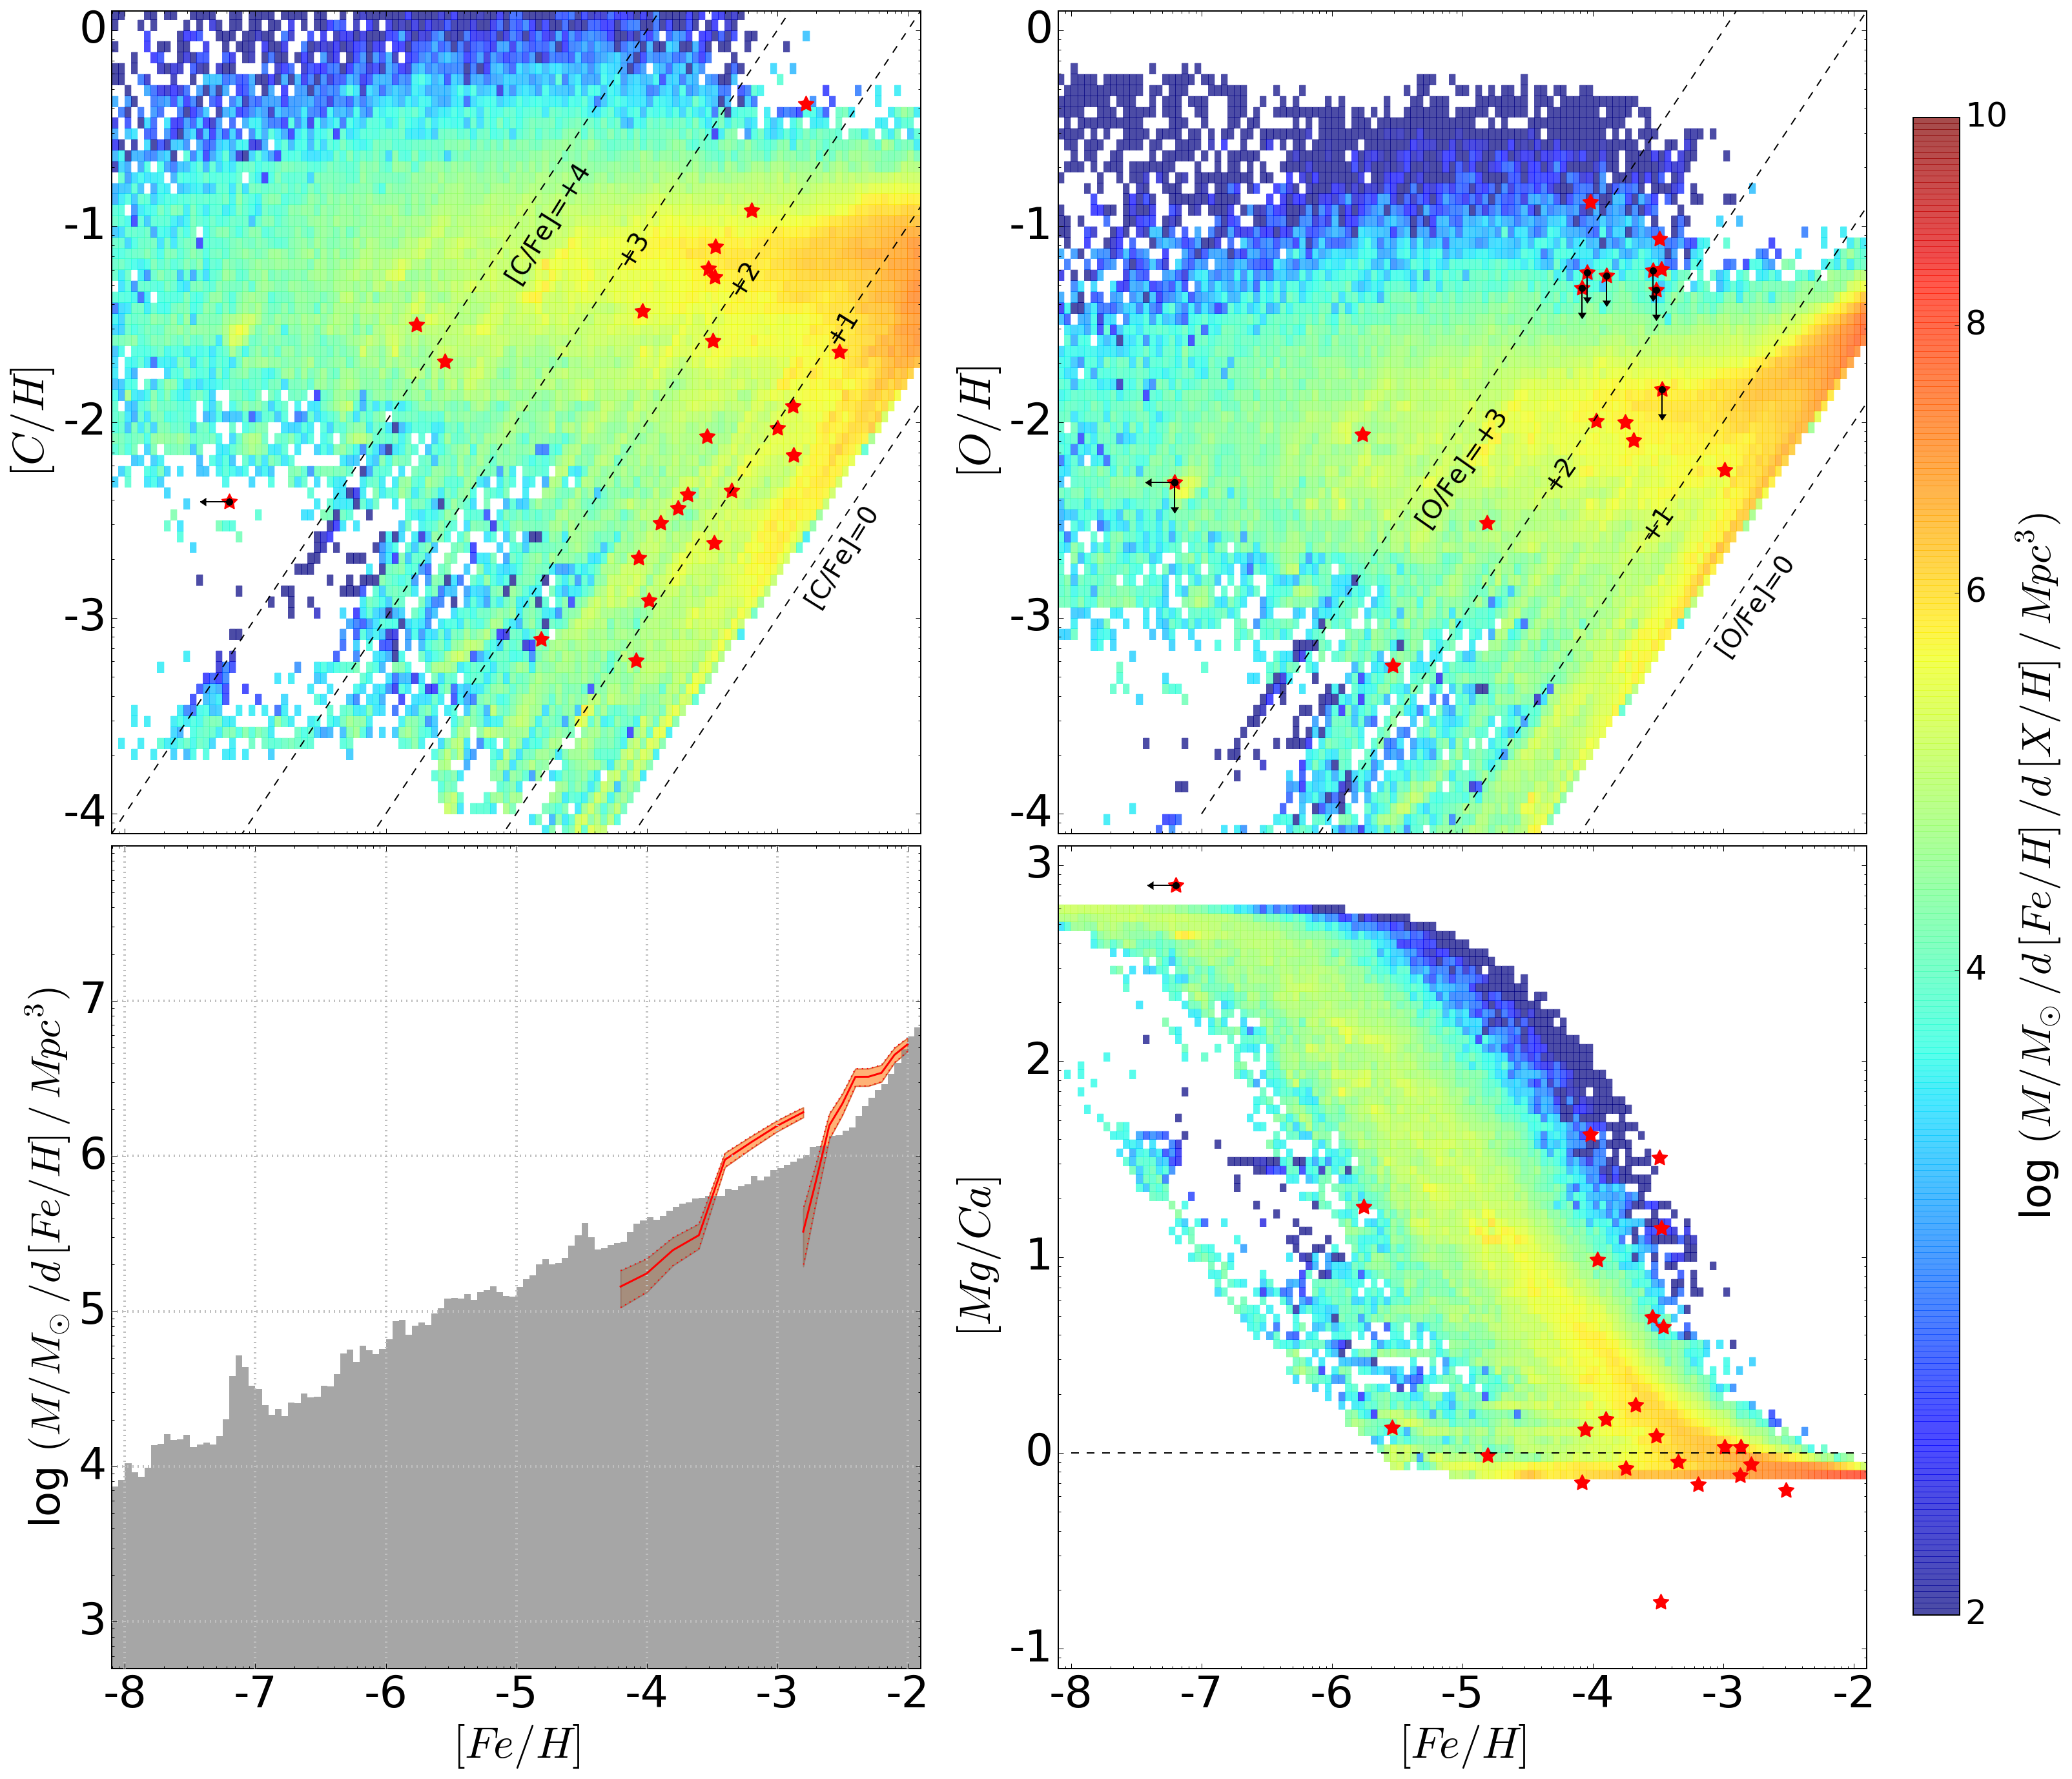

In [74]:
fig = plt.figure(figsize=(25, 23))
gs = gridspec.GridSpec(2,2,height_ratios=[1,1], width_ratios=[1,1], wspace=0.17, hspace=0.015)
#gs.update(hspace=0.25)
ca = plt.subplot(gs[:-1,0])
ox = plt.subplot(gs[:-1,1])
mg = plt.subplot(gs[1:,1])
axHistx = plt.subplot(gs[1:,0])

labelsize = 34

#f, (axHistx, mg, ca, ox) = plt.subplots(4, sharex=True, height_ratios=[4,1] )

nullfmt = NullFormatter()

xrange = np.logspace(-9,0,181)
yrange = np.logspace(-4,4,181)
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(Mg_mixedF60/Mgsun / (Ca_mixedF60/Casun), Fe_mixedF60/Fesun, 
                                   weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                   bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

minY = -1.1; maxY = 3.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10

histMax = 8
rotAngle = 58.0

#
# We need to generate bins first, but we need to generate these plots 'first' ... run twice.
#
axHistx.loglog(MDF0_scaled[1:,0], MDF0_scaled[1:,1], ls='-', lw=1.5, color='r') 
axHistx.loglog(MDF0_scaled[1:,0], MDF0_upper_scaled[1:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF0_scaled[1:,0], MDF0_lower_scaled[1:,1], ls=':', lw=1, color='r') 

axHistx.loglog(MDF1_scaled[:,0], MDF1_scaled[:,1], ls='-', lw=1.5,color='r') 
axHistx.loglog(MDF1_scaled[:,0], MDF1_upper_scaled[:,1], ls=':', lw=1, color='r') 
axHistx.loglog(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], ls=':', lw=1, color='r') 


# Build the x-axis 1D histogram
# Generate the xy axes histograms
N, bins, patches = axHistx.hist(Fe_mixedF60/Fesun, bins=xrange, log=True, edgecolor='none', alpha=0.70,color='grey',
                                weights=masses[mixedStar] * (1.0 - spPF[mixedStar]))
normBarHeight(bins, patches, cmvol)
axHistx.set_xscale("log")
#colorHistOnHeight(N, bins, patches, cmvol, cbarMin, cbarMax)

# Setup format of the histograms
axHistx.set_xlim([10**minX,10**maxX])
axHistx.set_ylim([10**2.7,10.0**histMax])     # Constant range for all histograms
axHistx.tick_params(labelsize=labelsize)
axHistx.tick_params(axis='x', labelsize=labelsize)
#ox.tick_params(axis='y', labelsize=labelsize)
axHistx.xaxis.set_ticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
axHistx.yaxis.set_ticks([1e3, 1e4, 1e5, 1e6, 1e7])
axHistx.grid(color='0.75', linestyle=':', linewidth=2)
axHistx.xaxis.set_major_formatter(custom_formatter)
axHistx.yaxis.set_major_formatter(custom_formatter) # Use integers for ticks
axHistx.set_xlabel("$[Fe/H]$", size=34)
axHistx.set_ylabel("log $(M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$", size=32)
#axHistx.yaxis.set_label_position("right")
#axHistx.set_ylabel("$log\, (M/M_{\odot}\, / d\,[Fe/H]\, /\, Mpc^{3})$",size=24) # Use integers for ticks

axHistx.fill_between(MDF0_scaled[1:,0], MDF0_lower_scaled[1:,1], MDF0_upper_scaled[1:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

axHistx.fill_between(MDF1_scaled[:,0], MDF1_lower_scaled[:,1], MDF1_upper_scaled[:,1],
                     alpha=0.75, edgecolor='#CC4F1B', facecolor='#FF9848')

yLabel = "[Mg/Ca]"

# Plot [Mg/Ca]
mg.tick_params(axis='x', labelsize=labelsize)
mg.tick_params(axis='y', labelsize=labelsize)
mg.set_xlabel("$[Fe/H]$", size=34)
mg.set_ylabel("$"+yLabel+"$", size=34)
mg.set_xlim([10**minX,10**maxX])
mg.set_ylim([10**minY,10**maxY])
mg.set_xscale('log')
mg.set_yscale('log')

mg.xaxis.set_major_formatter(custom_formatter)
mg.yaxis.set_major_formatter(custom_formatter)

###
## Plot [Mg/Ca]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cmg = (mg.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

# Add Keller CEMP star points
mg.errorbar(10**MgCaFeH[0,0],10**MgCaFeH[0,1], fmt='k.', markersize=10,
                  xerr=4e-1*10**MgCaFeH[0,0], xuplims=True)
mg.scatter(10**MgCaFeH[:,0],10**MgCaFeH[:,1], s=150, c="r" ,marker=(5,1), edgecolor='r')

cfeZero,  = mg.plot(np.array([1e-8,1e-2]),np.array([1,1]), 'k--')

#
# Add a colorbar
#
# cbarticks = [2,4,6, 8, cbarMax]
# cax, kw = mpl.colorbar.make_axes([ax for ax in [mg]], location='right')
# cbar = plt.colorbar(cmg, cax=cax, ticks=cbarticks, **kw)
# cbar.ax.set_yticklabels(cbarticks, size=26)
# cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[Mg/Ca]\, /\, Mpc^{3})$", size=32)
# cbar.ax.set_aspect('auto')
# cbar.ax.set_position((0.85, 0.523, 0.02, 0.36))


xrange = np.logspace(-9,0,181)
yrange = np.logspace(-9,1,181)

##
## [C/H]
##
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"

yLabel = "[C/H]"
H, xedges, yedges = np.histogram2d(C_mixedF60/Csun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)

cbarMin = 2
cbarMax = 10

minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9

ca.tick_params(axis='x', labelsize=labelsize)
ca.tick_params(axis='y', labelsize=labelsize)
#ca.set_xlabel("$[Fe/H]$", size=34)
ca.set_ylabel("$"+yLabel+"$", size=34)
ca.set_xlim([10**minX,10**maxX])
ca.set_ylim([10**minY,10**maxY])
ca.set_xscale('log')
ca.set_yscale('log')

###
## Plot [C/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0
## Create a plot of the binned data, use a fixed lognormal scale
cca = (ca.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ca.annotate('[C/Fe]=0', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ca.annotate('+1', xy=(10**-5.9, 10**-4), xytext=(10**-2.5, 10**-1.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ca.annotate('+2', xy=(10**-5.9, 10**-4), xytext=(10**-3.25, 10**-1.25), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeThree,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+3),10**(2)]), 'k--')
ca.annotate('+3', xy=(10**-5.9, 10**-4), xytext=(10**-4.1, 10**-1.1), 
                  horizontalalignment='center',size=20,rotation=rotAngle)
cfeFour,  = ca.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+4),10**(3)]), 'k--')
ca.annotate('[C/Fe]=+4', xy=(10**-5.9, 10**-4), xytext=(10**-4.75, 10**-0.75), 
                  horizontalalignment='center',size=20,rotation=rotAngle)

ca.xaxis.set_major_formatter(nullfmt)
ca.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
ca.errorbar(10**CHFeH[0,0],10**CHFeH[0,1], fmt='k.', markersize=10,
                  xerr=4e-1*10**CHFeH[0,0], xuplims=True)
ca.scatter(10**CHFeH[:,0],10**CHFeH[:,1], s=150, c="r" ,marker=(5,1), edgecolor='r')


##
## [O/H]
##
X, Y = np.meshgrid(xrange, yrange)  # Create a grid over the range of bins for the plotxLabel = "[O/H]"
yLabel = "[O/H]"

H, xedges, yedges = np.histogram2d(O_mixedF60/Osun, Fe_mixedF60/Fesun, weights=masses[mixedStar] * (1.0 - spPF[mixedStar]), 
                                            bins=(yrange,xrange))
# Compute the normalizing factors... 
H = H / cmvol # Normalize by comoving volume (now we're per Mpc)
dx = np.diff(np.log10(xrange))
dy = np.diff(np.log10(yrange))
area = dx[:, None] * dy # compute the area of each bin using broadcasting
H = H / area # Normalize by bin area
H = np.log10(np.ma.masked_where(H == 0.0,H))
H = np.ma.masked_invalid(H)


minY = -4.1; maxY = 0.1
minX = -8.1; maxX = -1.9
cbarMin = 2
cbarMax = 10
rotAngle= 55

ox.tick_params(axis='x', labelsize=labelsize)
ox.tick_params(axis='y', labelsize=labelsize)
#ox.set_xlabel("$[Fe/H]$", size=34)
ox.set_ylabel("$"+yLabel+"$", size=34)
ox.set_xlim([10**minX,10**maxX])
ox.set_ylim([10**minY,10**maxY])
ox.set_xscale('log')
ox.set_yscale('log')
#ax2dhist.grid(True, which='both', color='0.1', alpha=0.5, linestyle=':', linewidth=1)
cfeZero,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9),10**(-1)]), 'k--')
ox.annotate('[O/Fe]=0', xy=(10**-6.9, 10**-4), xytext=(10**-2.75, 10**-2.75),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeOne,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+1),10**(0)]), 'k--')
ox.annotate('+1', xy=(10**-6.9, 10**-4), xytext=(10**-3.5, 10**-2.5),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeTwo,  = ox.plot(np.array([10**(-9),10**-1]),np.array([10**(-9+2),10**(1)]), 'k--')
ox.annotate('+2', xy=(10**-6.9, 10**-4), xytext=(10**-4.25, 10**-2.25),
                  horizontalalignment='center',size=20,rotation=rotAngle ) 
cfeThree, = ox.plot(np.array([10**(-7),10**-2]),np.array([10**(-7+3),10**(1)]), 'k--')
ox.annotate('[O/Fe]=+3', xy=(10**-6.9, 10**-4), xytext=(10**-5.0, 10**-2.0),
                  horizontalalignment='center', size=20,rotation=rotAngle ) 

ox.xaxis.set_major_formatter(nullfmt)
ox.yaxis.set_major_formatter(custom_formatter)

# Add Keller CEMP star points
###
## Plot [O/H]
###
cmap = copy.copy(mpl.cm.jet)
cmap.set_bad('w', 1.)  # w is color, for values of 1.0

## Create a plot of the binned data, use a fixed lognormal scale
cox = (ox.pcolormesh(X, Y, H, cmap=cmap, norm=LogNorm(vmin=cbarMin,vmax=cbarMax),alpha=0.70))

ox.errorbar(10**np.take(OHFeH,Oindices)[:,0],10**np.take(OHFeH,Oindices)[:,1], fmt='k.', markersize=10,
                  yerr=0.3*10**np.take(OHFeH,Oindices)[:,1], uplims=True)
ox.errorbar(10**OHFeH[0,0],10**OHFeH[0,1], fmt='k.', markersize=10,
                  xerr=4e-1*10**OHFeH[0,0], xuplims=True)
ox.scatter(10**OHFeH[:,0],10**OHFeH[:,1], s=150, c="r" ,marker=(5,1), edgecolor='r')
ox.set_ylim([10**minY,10**maxY])

#
# Add a colorbar
#
cbarticks = [2,4,6, 8, cbarMax]
# cax, kw = mpl.colorbar.make_axes([ax for ax in [ox]], location='right')
# #cax.set_yticklabels(cbarticks, size=26)
# #cax.set_label("$log\, (M\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$ ", size=34)
# cbar = plt.colorbar(cox, cax=cax, ticks=cbarticks, **kw)
# cbar.ax.set_yticklabels(cbarticks, size=26)
# cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$", size=32)
# cbar.ax.set_aspect('auto')
# cbar.ax.set_position((0.85, 0.13, 0.02, 0.36))

##
## Try one color bar
##
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cox, cax=cbar_ax, format=custom_formatter, ticks=cbarticks)
cbar.ax.set_yticklabels(cbarticks, size=26)
cbar.set_label("log $(M/M_{\odot}\, / d\,[Fe/H]\, / d\,[X/H]\, /\, Mpc^{3})$", fontsize=32)
ox.set_ylim([10**minY,10**0.1])

plt.savefig("metals_fpol.pdf", dpi=fig.dpi,bbox_inches='tight')
plt.show()


In [67]:
gc.collect()

673

In [71]:
del fig, ox, ca, mg, axHistx

58.0